In [2]:
%load_ext autoreload
%autoreload 2
import json
import os
import sys

import keras.backend as K
from keras.models import load_model
from keras.optimizers import Adam
import numpy as np
import tensorflow as tf

from dataset_utils import adni_loader
#from networks import transform_network_utils

sys.path.append('../neuron')
sys.path.append('../voxelmorph')
import src.losses as vm_losses

gpu_ids = [3]
# set gpu id and tf settings
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(g) for g in gpu_ids])
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))

import sys
sys.path.append('../voxelmorph-sandbox')
import voxelmorph.networks as vm_networks
import tensorflow as tf
from voxelmorph import dense_3D_spatial_transformer
from keras.models import load_model
 
sys.path.append('../neuron')
import neuron.layers as nrn_layers
import neuron.utils as nrn_utils
sys.path.append('../voxelmorph-sandbox')
import voxelmorph.networks as vm_networks
from voxelmorph.dense_3D_spatial_transformer import Dense3DSpatialTransformer

start_iter = 10000
# voxelmorph_model = load_model(
#     #'/afs/csail.mit.edu/u/x/xamyzhao/voxelmorph/models/vm2_cc.h5',
#     './experiments/voxelmorph/vm2_cc_AtoUMS_newdataset_iter100000.h5',#.format(start_iter),
#     custom_objects={'Dense3DSpatialTransformer': Dense3DSpatialTransformer,
#                    'SpatialTransformer': nrn_layers.SpatialTransformer,
#                    },
#     compile=False,
# )
voxelmorph_model = load_model(
    #'./experiments/voxelmorph/vm2_cc_AtoUMS_100k_CStoUMS_xy_iter{}.h5'.format(start_iter),
    #'./experiments/voxelmorph/vm2_cc_AtoUMS_100k_CStoUMS_xy_iter100000.h5',
    './experiments/voxelmorph/vm2_cc_AtoUMS_100k_UMStoCS_xy_iter52000.h5',
    custom_objects={'Dense3DSpatialTransformer': dense_3D_spatial_transformer.Dense3DSpatialTransformer, 
                    'interp_upsampling': vm_networks.interp_upsampling,
                    'meshgrid': vm_networks.meshgrid,
                    'tf': tf,
                    
                    'VecInt': nrn_layers.VecInt,
                    'SpatialTransformer': nrn_layers.SpatialTransformer,
                    'nrn_utils': nrn_utils,
                    'nrn_layers': nrn_layers,
                   },
    compile=False,
)

Using TensorFlow backend.
../cnn_utils/vis_utils.py:14: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('Agg')


[(None, 160, 192, 224, 1), (None, 160, 192, 224, 3)]


Load training dataset

In [3]:
dataset_key = 'adni-1000-csts2'
import vte_runner
data_params = vte_runner.named_vte_data_params[dataset_key]
    
ds = adni_loader.ADNIDataset(data_params)
data_params['load_vols'] = False

vol_shape = tuple(data_params['img_shape'])

# just load some examples so we can get the image size, but actually use a generator later...
(X_unlabeled, _, ids_unlabeled),\
(X_labeled_train, Y_labeled_train, ids_labeled_train), \
(X_labeled_valid, Y_labeled_valid, ids_labeled_valid), \
label_mapping \
= ds.load_dataset(debug=False)

../cnn_utils/vis_utils.py:14: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('Agg')


Loading adni dataset adni-unnorm-masked_1000ul_subj-OASIS_OAS1_0327-l
Params: {'dataset_name': 'adni', 'source_name': 'centroidsubj2', 'target_name': 'subjs', 'unnormalized': True, 'masked': True, 'n_shot': 1, 'use_atlas_as_source': False, 'use_subject': 'OASIS_OAS1_0327_MR1_mri_talairach_orig', 'img_shape': (160, 192, 224, 1), 'pred_img_shape': (160, 192, 1), 'aug_img_shape': (160, 192, 224, 1), 'n_unlabeled': 1000, 'n_validation': 50, 'load_vols': False, 'aug_in_gen': True, 'n_vte_aug': None, 'n_flow_aug': None, 'use_labels': [0, 16, 10, 49, 8, 47, 4, 43, 7, 46, 12, 51, 2, 41, 28, 60, 11, 50, 13, 52, 17, 53, 14, 15, 18, 54, 24, 3, 42, 31, 63], 'final_test': False, 'warp_labels': True, 'n_dims': 3, 'orig_img_shape': (160, 192, 224, 1), 'scale': 1.0, 'split_id': None}
Got list of 7329 files from /data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/*.npz:
ADNI_ADNI-3T-FS-5.3-Long_293689.long.016_S_4591_base_mri_talairach_orig.npz
ADNI_ADNI-3T-FS-5.3-Long_78841.long.016_

(1, 160, 192, 224, 1)
(1, 160, 192, 224, 1)
(1, 160, 192, 224, 1)
['/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/OASIS_OAS1_0327_MR1_mri_talairach_orig.npz']
False


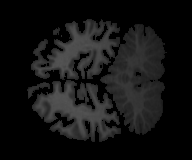

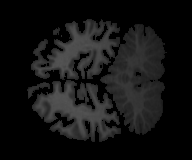

In [4]:
print(X_unlabeled.shape)
print(X_labeled_train.shape)
print(X_labeled_valid.shape)
print(ds.files_labeled_train)
print(ds.params['load_vols'])
import IPython
import PIL
IPython.display.display(PIL.Image.fromarray((X_labeled_train[0, :, :, 64, 0]*255).astype(np.uint8)))
IPython.display.display(PIL.Image.fromarray((X_unlabeled[0, :, :, 64, 0]*255).astype(np.uint8)))


In [5]:
# create voxelmorph model
sys.path.append('../voxelmorph')
import src.networks as vm_networks

nf_enc = [16, 32, 32, 32]
nf_dec = [32, 32, 32, 32, 32, 16, 16]

# vm2 model
vm_new_model = vm_networks.cvpr2018_net(
    vol_size=(160, 192, 224),
    enc_nf=nf_enc, 
    dec_nf=nf_dec,
    indexing='xy'
)


[(None, 160, 192, 224, 1), (None, 160, 192, 224, 3)]


In [6]:
vm_new_model.summary()
import data_utils
import src.losses as vm_losses

# just train voxelmorph
vm_new_model.compile(
    #loss=['mean_squared_error', vm_losses.gradientLoss('l2')],
    #loss=[vm_losses.cc3D(), vm_losses.gradientLoss('l2')],
    loss=[vm_losses.NCC().loss, vm_losses.Grad('l2').loss],
          #vm_losses.gradientLoss('l2')],
    #loss_weights=[1.0, ,0.01],
    loss_weights=[1.0, 1.],#0.01],
    #loss_weights=[1., 1., 1., 0.],#0.01],
    optimizer=Adam(0.0001)
)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 192, 224 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 160, 192, 224 0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 160, 192, 224 0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 80, 96, 112,  880         concatenate_1[0][0]              
__________

In [7]:

# copy weights from regular voxelmorph as initialization
for li, l in enumerate(vm_new_model.layers):
    print(l.name)
    if l.name == voxelmorph_model.layers[li].name:
        print(l.name)
        vm_new_model.layers[li].set_weights(voxelmorph_model.layers[li].get_weights())

input_1
input_1
input_2
input_2
concatenate_1
concatenate_1
conv3d_1
conv3d_1
leaky_re_lu_1
leaky_re_lu_1
conv3d_2
conv3d_2
leaky_re_lu_2
leaky_re_lu_2
conv3d_3
conv3d_3
leaky_re_lu_3
leaky_re_lu_3
conv3d_4
conv3d_4
leaky_re_lu_4
leaky_re_lu_4
conv3d_5
conv3d_5
leaky_re_lu_5
leaky_re_lu_5
up_sampling3d_1
up_sampling3d_1
concatenate_2
concatenate_2
conv3d_6
conv3d_6
leaky_re_lu_6
leaky_re_lu_6
up_sampling3d_2
up_sampling3d_2
concatenate_3
concatenate_3
conv3d_7
conv3d_7
leaky_re_lu_7
leaky_re_lu_7
up_sampling3d_3
up_sampling3d_3
concatenate_4
concatenate_4
conv3d_8
conv3d_8
leaky_re_lu_8
leaky_re_lu_8
conv3d_9
conv3d_9
leaky_re_lu_9
leaky_re_lu_9
up_sampling3d_4
up_sampling3d_4
concatenate_5
concatenate_5
conv3d_10
conv3d_10
leaky_re_lu_10
leaky_re_lu_10
conv3d_11
conv3d_11
leaky_re_lu_11
leaky_re_lu_11
flow
flow
spatial_transformer_1
spatial_transformer_1


/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/OASIS_OAS1_0327_MR1_mri_talairach_orig.npz


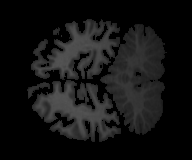

In [8]:
print(ds.files_labeled_train[0])
# source_X = ds.X_atlas
source_X, _ = adni_loader._load_vol_and_seg(ds.files_labeled_train[0], load_seg=False, mask_vol=ds.params['masked'])
source_X = source_X[np.newaxis]
IPython.display.display(PIL.Image.fromarray((source_X[0, :, :, 64, 0]*255).astype(np.uint8)))



In [ ]:
start_iter = 0
print(start_iter)
n_train_iters = 50000
vol_gen = ds.gen_vols_batch(['labeled_train', 'unlabeled_train'], batch_size=1, randomize=True)
print(ds.files_labeled_train + ds.files_unlabeled_train)
#vol_gen = data_utils.gen_batch(X_unlabeled, X_unlabeled, batch_size=1, randomize=True)
target_X, _ = next(vol_gen)
zeros_flow = np.zeros(target_X.shape[:-1] + (3,))

for bi in range(n_train_iters + 1):
    
    target_X, _ = next(vol_gen)
    # backward -- subject to atlas
    vm_losses = vm_new_model.train_on_batch([target_X, source_X], [source_X, zeros_flow])
    print('Iter {}, loss {}'.format(bi, vm_losses))
    
    if bi > 0 and bi % 2000 == 0:
        vm_new_model.save('./experiments/voxelmorph/vm2_cc_UMStoCS_52k_1k-ul_xy_iter{}.h5'.format(start_iter + bi))

0
['/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/OASIS_OAS1_0327_MR1_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-3T-FS-5.3-Long_263697.long.153_S_4077_base_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-3T-FS-5.3-Long_223532.long.153_S_2109_base_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-1.5T-FS-5.3-Long_76615.long.021_S_0984_base_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-3T-FS-5.3-Long_451346.long.009_S_0751_base_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/GSP_100329_NW33DK_FS_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-3T-FS-5.3-Long_282668.long.002_S_4270_base_mri_talairach_orig.npz', '/data/ddmg/voxelm

Iter 0, loss [-0.22609183, -0.26408532, 0.0379935]
Iter 1, loss [-0.21377166, -0.25163049, 0.037858833]
Iter 2, loss [-0.22200379, -0.25844133, 0.03643754]
Iter 3, loss [-0.21532628, -0.2538101, 0.038483825]
Iter 4, loss [-0.2078653, -0.2487014, 0.0408361]
Iter 5, loss [-0.21115392, -0.2566583, 0.04550436]
Iter 6, loss [-0.20134342, -0.24899997, 0.047656547]
Iter 7, loss [-0.21179242, -0.25262648, 0.04083405]
Iter 8, loss [-0.22255135, -0.26197672, 0.039425373]
Iter 9, loss [-0.22584291, -0.26018378, 0.034340873]
Iter 10, loss [-0.22254509, -0.25721988, 0.034674793]
Iter 11, loss [-0.2096554, -0.24907161, 0.03941621]
Iter 12, loss [-0.21634585, -0.2553789, 0.039033055]
Iter 13, loss [-0.1785507, -0.23180446, 0.05325375]
Iter 14, loss [-0.21496022, -0.25482672, 0.039866515]
Iter 15, loss [-0.23120248, -0.2681458, 0.036943316]
Iter 16, loss [-0.22922026, -0.26578352, 0.036563262]
Iter 17, loss [-0.22440614, -0.26196215, 0.037556008]
Iter 18, loss [-0.22819817, -0.2646094, 0.036411222]
It

Iter 154, loss [-0.22966851, -0.26560587, 0.035937358]
Iter 155, loss [-0.21334226, -0.2523008, 0.03895853]
Iter 156, loss [-0.22144322, -0.26148418, 0.04004095]
Iter 157, loss [-0.21077695, -0.24615465, 0.035377692]
Iter 158, loss [-0.21767654, -0.25607613, 0.038399592]
Iter 159, loss [-0.21904454, -0.25870976, 0.039665215]
Iter 160, loss [-0.20712271, -0.24948712, 0.0423644]
Iter 161, loss [-0.21799721, -0.25727543, 0.03927822]
Iter 162, loss [-0.22102442, -0.25999272, 0.03896829]
Iter 163, loss [-0.2208351, -0.25991288, 0.039077777]
Iter 164, loss [-0.22389966, -0.26119965, 0.037299994]
Iter 165, loss [-0.22171897, -0.26151693, 0.039797954]
Iter 166, loss [-0.21861073, -0.25767857, 0.039067827]
Iter 167, loss [-0.20739044, -0.246976, 0.03958556]
Iter 168, loss [-0.21663237, -0.25476784, 0.03813547]
Iter 169, loss [-0.21387985, -0.25137165, 0.0374918]
Iter 170, loss [-0.21580677, -0.25517252, 0.03936575]
Iter 171, loss [-0.22423252, -0.2605961, 0.036363572]
Iter 172, loss [-0.2214688

Iter 306, loss [-0.21668911, -0.25649512, 0.039806005]
Iter 307, loss [-0.22227281, -0.26159894, 0.039326128]
Iter 308, loss [-0.21507548, -0.25503606, 0.039960574]
Iter 309, loss [-0.18823273, -0.23438011, 0.046147376]
Iter 310, loss [-0.2223316, -0.2598259, 0.03749429]
Iter 311, loss [-0.21402769, -0.2532486, 0.039220918]
Iter 312, loss [-0.21654512, -0.2553223, 0.038777187]
Iter 313, loss [-0.2058406, -0.24589197, 0.040051375]
Iter 314, loss [-0.19833173, -0.241115, 0.04278327]
Iter 315, loss [-0.23041052, -0.26618582, 0.035775296]
Iter 316, loss [-0.2045076, -0.24772261, 0.043215003]
Iter 317, loss [-0.22828275, -0.26530275, 0.03701999]
Iter 318, loss [-0.22789581, -0.26554716, 0.03765135]
Iter 319, loss [-0.22964941, -0.26775163, 0.03810222]
Iter 320, loss [-0.20963491, -0.25381762, 0.0441827]
Iter 321, loss [-0.22215357, -0.26090753, 0.038753957]
Iter 322, loss [-0.22065288, -0.25773647, 0.037083596]
Iter 323, loss [-0.19820195, -0.23555264, 0.037350684]
Iter 324, loss [-0.220943

Iter 458, loss [-0.22924574, -0.26605102, 0.03680529]
Iter 459, loss [-0.21567436, -0.25594634, 0.04027198]
Iter 460, loss [-0.22074686, -0.2608568, 0.040109947]
Iter 461, loss [-0.20212612, -0.24654536, 0.044419236]
Iter 462, loss [-0.21297917, -0.2541112, 0.041132025]
Iter 463, loss [-0.2210914, -0.25926918, 0.03817777]
Iter 464, loss [-0.22878906, -0.26412678, 0.03533772]
Iter 465, loss [-0.22222146, -0.25860193, 0.036380462]
Iter 466, loss [-0.22127914, -0.2590154, 0.03773626]
Iter 467, loss [-0.20915984, -0.24967392, 0.040514078]
Iter 468, loss [-0.2225255, -0.25792634, 0.035400838]
Iter 469, loss [-0.22846928, -0.2656736, 0.037204318]
Iter 470, loss [-0.23336214, -0.26987842, 0.03651627]
Iter 471, loss [-0.21512243, -0.255139, 0.040016558]
Iter 472, loss [-0.21920094, -0.2594676, 0.040266655]
Iter 473, loss [-0.22322771, -0.26270244, 0.039474733]
Iter 474, loss [-0.22833274, -0.264713, 0.036380243]
Iter 475, loss [-0.22811443, -0.26441467, 0.03630024]
Iter 476, loss [-0.21638432,

Iter 610, loss [-0.22228144, -0.2593171, 0.03703566]
Iter 611, loss [-0.21353944, -0.25097188, 0.037432447]
Iter 612, loss [-0.21884036, -0.2574577, 0.03861734]
Iter 613, loss [-0.22125341, -0.261166, 0.039912593]
Iter 614, loss [-0.22915302, -0.2655108, 0.03635777]
Iter 615, loss [-0.22938071, -0.2662904, 0.036909685]
Iter 616, loss [-0.1459207, -0.2051613, 0.059240617]
Iter 617, loss [-0.21727294, -0.25606307, 0.038790133]
Iter 618, loss [-0.2114676, -0.2520244, 0.04055682]
Iter 619, loss [-0.21813664, -0.2553075, 0.037170865]
Iter 620, loss [-0.22611333, -0.26350182, 0.03738849]
Iter 621, loss [-0.226235, -0.26435417, 0.038119167]
Iter 622, loss [-0.21285924, -0.25444558, 0.041586332]
Iter 623, loss [-0.22240953, -0.26147556, 0.039066028]
Iter 624, loss [-0.22272247, -0.2631563, 0.040433824]
Iter 625, loss [-0.21960779, -0.25803685, 0.03842907]
Iter 626, loss [-0.22561516, -0.2625272, 0.036912035]
Iter 627, loss [-0.17799667, -0.22811243, 0.05011576]
Iter 628, loss [-0.210038, -0.24

Iter 762, loss [-0.23316813, -0.26776507, 0.034596946]
Iter 763, loss [-0.22591302, -0.26222733, 0.0363143]
Iter 764, loss [-0.13429765, -0.19668385, 0.062386196]
Iter 765, loss [-0.21620062, -0.2566215, 0.04042089]
Iter 766, loss [-0.22613832, -0.26185, 0.035711672]
Iter 767, loss [-0.22309259, -0.26023754, 0.03714495]
Iter 768, loss [-0.21633962, -0.25408968, 0.037750073]
Iter 769, loss [-0.21652092, -0.25619677, 0.039675847]
Iter 770, loss [-0.22431692, -0.26187924, 0.037562303]
Iter 771, loss [-0.14951465, -0.2043074, 0.054792758]
Iter 772, loss [-0.2274192, -0.26436412, 0.03694493]
Iter 773, loss [-0.22558841, -0.26251116, 0.03692276]
Iter 774, loss [-0.2222879, -0.25982794, 0.037540045]
Iter 775, loss [-0.21744093, -0.2556017, 0.038160764]
Iter 776, loss [-0.22873123, -0.26227728, 0.033546045]
Iter 777, loss [-0.21920592, -0.25814018, 0.038934257]
Iter 778, loss [-0.23017466, -0.2659584, 0.035783745]
Iter 779, loss [-0.22433552, -0.26199472, 0.0376592]
Iter 780, loss [-0.22146736

Iter 914, loss [-0.22272694, -0.26071692, 0.03798998]
Iter 915, loss [-0.22379933, -0.2616087, 0.037809357]
Iter 916, loss [-0.22564326, -0.26300684, 0.037363574]
Iter 917, loss [-0.20733953, -0.25160196, 0.04426243]
Iter 918, loss [-0.21668643, -0.2558177, 0.03913128]
Iter 919, loss [-0.23027055, -0.26758623, 0.037315678]
Iter 920, loss [-0.22211349, -0.26290268, 0.04078918]
Iter 921, loss [-0.20659617, -0.24794957, 0.041353405]
Iter 922, loss [-0.21171135, -0.25485343, 0.043142073]
Iter 923, loss [-0.2174597, -0.25852513, 0.041065436]
Iter 924, loss [-0.23067531, -0.26663882, 0.0359635]
Iter 925, loss [-0.22970499, -0.26574087, 0.03603588]
Iter 926, loss [-0.19807538, -0.23926048, 0.04118509]
Iter 927, loss [-0.22248021, -0.2616367, 0.03915649]
Iter 928, loss [-0.2251526, -0.26365525, 0.03850265]
Iter 929, loss [-0.20811442, -0.25216824, 0.044053815]
Iter 930, loss [-0.22550793, -0.26390857, 0.038400635]
Iter 931, loss [-0.2223374, -0.26043713, 0.03809973]
Iter 932, loss [-0.22294302

Iter 1065, loss [-0.21231546, -0.25407448, 0.04175903]
Iter 1066, loss [-0.22391218, -0.2610119, 0.037099726]
Iter 1067, loss [-0.23374975, -0.26873028, 0.034980543]
Iter 1068, loss [-0.22428733, -0.25961202, 0.0353247]
Iter 1069, loss [-0.15063724, -0.20507248, 0.054435235]
Iter 1070, loss [-0.19668242, -0.24061581, 0.04393339]
Iter 1071, loss [-0.22220224, -0.26064256, 0.038440324]
Iter 1072, loss [-0.2305319, -0.2666306, 0.03609868]
Iter 1073, loss [-0.22310206, -0.26086274, 0.03776067]
Iter 1074, loss [-0.21915847, -0.25852782, 0.039369337]
Iter 1075, loss [-0.21889642, -0.25814942, 0.039252996]
Iter 1076, loss [-0.14583227, -0.20800741, 0.062175136]
Iter 1077, loss [-0.22312602, -0.26064837, 0.03752235]
Iter 1078, loss [-0.21844874, -0.25709614, 0.038647395]
Iter 1079, loss [-0.22427005, -0.2604977, 0.036227636]
Iter 1080, loss [-0.22714274, -0.26293844, 0.035795704]
Iter 1081, loss [-0.21362932, -0.24986434, 0.03623502]
Iter 1082, loss [-0.22828537, -0.26412782, 0.03584245]
Iter 

Iter 1214, loss [-0.20769161, -0.24921563, 0.04152403]
Iter 1215, loss [-0.21753357, -0.25681195, 0.039278373]
Iter 1216, loss [-0.18573457, -0.23203129, 0.046296716]
Iter 1217, loss [-0.22504647, -0.2597429, 0.034696415]
Iter 1218, loss [-0.20983036, -0.24604052, 0.03621016]
Iter 1219, loss [-0.22285147, -0.2590735, 0.036222022]
Iter 1220, loss [-0.2127186, -0.2508027, 0.038084086]
Iter 1221, loss [-0.22363968, -0.26059264, 0.036952958]
Iter 1222, loss [-0.23204651, -0.26776594, 0.03571942]
Iter 1223, loss [-0.22898668, -0.26751465, 0.038527966]
Iter 1224, loss [-0.18630435, -0.23641314, 0.050108787]
Iter 1225, loss [-0.21964847, -0.2603696, 0.04072113]
Iter 1226, loss [-0.22878776, -0.2648, 0.036012247]
Iter 1227, loss [-0.22096953, -0.25955343, 0.0385839]
Iter 1228, loss [-0.22420767, -0.2601486, 0.03594094]
Iter 1229, loss [-0.22054657, -0.25904417, 0.03849759]
Iter 1230, loss [-0.22681603, -0.26229033, 0.035474293]
Iter 1231, loss [-0.1967759, -0.24041523, 0.04363933]
Iter 1232, l

Iter 1363, loss [-0.21680358, -0.2562605, 0.039456926]
Iter 1364, loss [-0.21229887, -0.2524388, 0.040139936]
Iter 1365, loss [-0.22910765, -0.2652924, 0.036184754]
Iter 1366, loss [-0.1706922, -0.22500262, 0.05431041]
Iter 1367, loss [-0.1567229, -0.20848992, 0.051767014]
Iter 1368, loss [-0.14564581, -0.2035643, 0.057918485]
Iter 1369, loss [-0.16807665, -0.22094804, 0.052871387]
Iter 1370, loss [-0.2222195, -0.2612888, 0.039069302]
Iter 1371, loss [-0.22601877, -0.2620287, 0.03600992]
Iter 1372, loss [-0.22266102, -0.25949013, 0.036829107]
Iter 1373, loss [-0.21956147, -0.25869745, 0.039135978]
Iter 1374, loss [-0.16536437, -0.22129948, 0.055935115]
Iter 1375, loss [-0.21433364, -0.25382894, 0.039495304]
Iter 1376, loss [-0.22675774, -0.26165044, 0.0348927]
Iter 1377, loss [-0.19277644, -0.23962852, 0.046852082]
Iter 1378, loss [-0.22291072, -0.25917315, 0.036262438]
Iter 1379, loss [-0.21283558, -0.25305617, 0.040220585]
Iter 1380, loss [-0.2294667, -0.26463988, 0.03517317]
Iter 13

Iter 1512, loss [-0.22406484, -0.26073676, 0.036671918]
Iter 1513, loss [-0.15913239, -0.2145145, 0.05538211]
Iter 1514, loss [-0.22260554, -0.26040375, 0.037798215]
Iter 1515, loss [-0.22943088, -0.2678186, 0.038387723]
Iter 1516, loss [-0.2075428, -0.2496077, 0.042064898]
Iter 1517, loss [-0.22921324, -0.26589015, 0.03667692]
Iter 1518, loss [-0.17366311, -0.22490634, 0.05124324]
Iter 1519, loss [-0.21745268, -0.2569381, 0.039485417]
Iter 1520, loss [-0.22856744, -0.26577297, 0.037205532]
Iter 1521, loss [-0.22554506, -0.2621413, 0.03659622]
Iter 1522, loss [-0.2268381, -0.26316148, 0.036323383]
Iter 1523, loss [-0.210545, -0.25163642, 0.04109141]
Iter 1524, loss [-0.22639942, -0.26400498, 0.037605546]
Iter 1525, loss [-0.14856383, -0.20954357, 0.060979735]
Iter 1526, loss [-0.22300825, -0.26038966, 0.03738141]
Iter 1527, loss [-0.22007158, -0.2583452, 0.03827361]
Iter 1528, loss [-0.2145704, -0.2552665, 0.04069608]
Iter 1529, loss [-0.21697377, -0.2564617, 0.039487943]
Iter 1530, lo

Iter 1661, loss [-0.2220782, -0.26132053, 0.039242327]
Iter 1662, loss [-0.20829418, -0.25005746, 0.04176327]
Iter 1663, loss [-0.22864914, -0.26598832, 0.03733919]
Iter 1664, loss [-0.20613867, -0.24693884, 0.04080017]
Iter 1665, loss [-0.2196001, -0.25848156, 0.038881466]
Iter 1666, loss [-0.22835243, -0.26395878, 0.035606354]
Iter 1667, loss [-0.22978874, -0.2636438, 0.03385507]
Iter 1668, loss [-0.22788237, -0.26509407, 0.037211705]
Iter 1669, loss [-0.22011387, -0.2581989, 0.038085014]
Iter 1670, loss [-0.18793952, -0.2400765, 0.05213697]
Iter 1671, loss [-0.22167382, -0.25842273, 0.036748916]
Iter 1672, loss [-0.21578722, -0.25623104, 0.040443823]
Iter 1673, loss [-0.21982682, -0.260507, 0.040680163]
Iter 1674, loss [-0.22498298, -0.26388133, 0.03889835]
Iter 1675, loss [-0.22378916, -0.26100278, 0.037213616]
Iter 1676, loss [-0.22730067, -0.26345605, 0.036155373]
Iter 1677, loss [-0.22215827, -0.25976267, 0.037604406]
Iter 1678, loss [-0.22395161, -0.26024228, 0.036290675]
Iter 

Iter 1810, loss [-0.22135794, -0.260789, 0.039431065]
Iter 1811, loss [-0.13315335, -0.19618282, 0.06302947]
Iter 1812, loss [-0.22653562, -0.26331443, 0.036778808]
Iter 1813, loss [-0.2160568, -0.25564453, 0.039587732]
Iter 1814, loss [-0.2229298, -0.2601712, 0.037241396]
Iter 1815, loss [-0.22464845, -0.26179883, 0.037150383]
Iter 1816, loss [-0.22778729, -0.26366282, 0.03587553]
Iter 1817, loss [-0.2213541, -0.2596116, 0.03825751]
Iter 1818, loss [-0.22177926, -0.26083168, 0.039052427]
Iter 1819, loss [-0.2292746, -0.26566005, 0.036385443]
Iter 1820, loss [-0.22755937, -0.26343226, 0.035872895]
Iter 1821, loss [-0.21052638, -0.25290358, 0.042377196]
Iter 1822, loss [-0.21532463, -0.25468642, 0.03936179]
Iter 1823, loss [-0.22121784, -0.26038566, 0.03916782]
Iter 1824, loss [-0.20809844, -0.24535823, 0.037259787]
Iter 1825, loss [-0.21543795, -0.25328344, 0.037845485]
Iter 1826, loss [-0.21456221, -0.25365612, 0.03909391]
Iter 1827, loss [-0.22542739, -0.26195064, 0.036523245]
Iter 1

Iter 1959, loss [-0.19019657, -0.23746409, 0.047267508]
Iter 1960, loss [-0.22482005, -0.2620224, 0.037202355]
Iter 1961, loss [-0.225462, -0.26307312, 0.037611112]
Iter 1962, loss [-0.20942068, -0.2490024, 0.039581724]
Iter 1963, loss [-0.23277034, -0.26953667, 0.036766335]
Iter 1964, loss [-0.22470245, -0.26287803, 0.03817559]
Iter 1965, loss [-0.22184771, -0.26096976, 0.039122052]
Iter 1966, loss [-0.2215656, -0.25730652, 0.03574091]
Iter 1967, loss [-0.2293936, -0.26662424, 0.037230633]
Iter 1968, loss [-0.22746491, -0.2606801, 0.033215195]
Iter 1969, loss [-0.21429172, -0.25483197, 0.040540256]
Iter 1970, loss [-0.22376388, -0.26293254, 0.039168663]
Iter 1971, loss [-0.2247945, -0.26430333, 0.03950882]
Iter 1972, loss [-0.21339378, -0.254398, 0.04100421]
Iter 1973, loss [-0.22510444, -0.26094976, 0.035845324]
Iter 1974, loss [-0.22194959, -0.26111215, 0.039162558]
Iter 1975, loss [-0.22748618, -0.26732352, 0.039837345]
Iter 1976, loss [-0.22266875, -0.26159313, 0.038924377]
Iter 1

Iter 2108, loss [-0.2296327, -0.2681273, 0.038494587]
Iter 2109, loss [-0.2213468, -0.26109162, 0.03974483]
Iter 2110, loss [-0.15474051, -0.21371135, 0.058970846]
Iter 2111, loss [-0.22401635, -0.26072925, 0.036712904]
Iter 2112, loss [-0.20603147, -0.24810565, 0.042074174]
Iter 2113, loss [-0.22119176, -0.25814906, 0.036957297]
Iter 2114, loss [-0.22529875, -0.2604722, 0.035173457]
Iter 2115, loss [-0.23018971, -0.26497537, 0.034785654]
Iter 2116, loss [-0.15731326, -0.21139815, 0.05408489]
Iter 2117, loss [-0.22085941, -0.2595724, 0.03871297]
Iter 2118, loss [-0.22634242, -0.26520237, 0.038859945]
Iter 2119, loss [-0.21776557, -0.25838566, 0.040620096]
Iter 2120, loss [-0.19579913, -0.24294299, 0.047143858]
Iter 2121, loss [-0.21921083, -0.25938064, 0.040169805]
Iter 2122, loss [-0.22585276, -0.26230574, 0.036452975]
Iter 2123, loss [-0.22338326, -0.25980332, 0.03642006]
Iter 2124, loss [-0.2273112, -0.2622692, 0.034957998]
Iter 2125, loss [-0.19366837, -0.23354623, 0.03987787]
Iter

Iter 2257, loss [-0.22243252, -0.2603709, 0.03793838]
Iter 2258, loss [-0.22863185, -0.26508564, 0.03645379]
Iter 2259, loss [-0.22550002, -0.2618133, 0.036313303]
Iter 2260, loss [-0.23148957, -0.26562196, 0.0341324]
Iter 2261, loss [-0.17452545, -0.22489695, 0.050371498]
Iter 2262, loss [-0.20169309, -0.24244674, 0.040753648]
Iter 2263, loss [-0.22232084, -0.26323265, 0.04091181]
Iter 2264, loss [-0.21470556, -0.2531441, 0.038438533]
Iter 2265, loss [-0.22520581, -0.26308984, 0.03788402]
Iter 2266, loss [-0.20666769, -0.24907707, 0.04240937]
Iter 2267, loss [-0.2195292, -0.25633243, 0.03680323]
Iter 2268, loss [-0.22591712, -0.2626156, 0.03669847]
Iter 2269, loss [-0.21150973, -0.24782546, 0.03631573]
Iter 2270, loss [-0.21303406, -0.25419363, 0.041159566]
Iter 2271, loss [-0.2337132, -0.27015364, 0.03644045]
Iter 2272, loss [-0.21978015, -0.25803402, 0.03825388]
Iter 2273, loss [-0.22860205, -0.26415843, 0.03555637]
Iter 2274, loss [-0.21857178, -0.2561436, 0.03757181]
Iter 2275, lo

Iter 2406, loss [-0.22577128, -0.26332662, 0.037555344]
Iter 2407, loss [-0.21833186, -0.25702175, 0.038689896]
Iter 2408, loss [-0.22174837, -0.26003104, 0.038282674]
Iter 2409, loss [-0.22764772, -0.2630793, 0.03543157]
Iter 2410, loss [-0.22679918, -0.26343203, 0.03663285]
Iter 2411, loss [-0.20175834, -0.24266826, 0.040909912]
Iter 2412, loss [-0.21560296, -0.25528064, 0.039677687]
Iter 2413, loss [-0.22217244, -0.260675, 0.03850258]
Iter 2414, loss [-0.2227285, -0.26048836, 0.037759855]
Iter 2415, loss [-0.23067138, -0.26657754, 0.035906162]
Iter 2416, loss [-0.2054805, -0.24548146, 0.04000096]
Iter 2417, loss [-0.21323147, -0.25382555, 0.040594067]
Iter 2418, loss [-0.22693539, -0.2658648, 0.0389294]
Iter 2419, loss [-0.22614756, -0.26235205, 0.036204483]
Iter 2420, loss [-0.21854715, -0.2592581, 0.040710937]
Iter 2421, loss [-0.23406565, -0.27023864, 0.036172982]
Iter 2422, loss [-0.22964391, -0.2661563, 0.036512367]
Iter 2423, loss [-0.21399243, -0.25579378, 0.04180135]
Iter 24

Iter 2555, loss [-0.21640033, -0.25720376, 0.04080343]
Iter 2556, loss [-0.2229634, -0.26102647, 0.038063075]
Iter 2557, loss [-0.22000895, -0.2581993, 0.038190346]
Iter 2558, loss [-0.2317833, -0.2655122, 0.03372889]
Iter 2559, loss [-0.22134447, -0.2600191, 0.038674623]
Iter 2560, loss [-0.22306249, -0.25863925, 0.03557677]
Iter 2561, loss [-0.22711885, -0.26483345, 0.0377146]
Iter 2562, loss [-0.22640303, -0.26510414, 0.038701117]
Iter 2563, loss [-0.23388198, -0.27091646, 0.03703449]
Iter 2564, loss [-0.22313808, -0.26315627, 0.040018186]
Iter 2565, loss [-0.23031643, -0.26689252, 0.0365761]
Iter 2566, loss [-0.22663832, -0.2642625, 0.03762418]
Iter 2567, loss [-0.21681222, -0.2564569, 0.039644685]
Iter 2568, loss [-0.23025435, -0.2655816, 0.03532725]
Iter 2569, loss [-0.21511824, -0.2542789, 0.03916065]
Iter 2570, loss [-0.22884631, -0.26607442, 0.037228115]
Iter 2571, loss [-0.22387321, -0.26384884, 0.039975632]
Iter 2572, loss [-0.22816479, -0.26749954, 0.03933475]
Iter 2573, lo

Iter 2704, loss [-0.22460389, -0.2623726, 0.03776873]
Iter 2705, loss [-0.168329, -0.22003505, 0.051706046]
Iter 2706, loss [-0.22377975, -0.26295722, 0.03917746]
Iter 2707, loss [-0.22950083, -0.26511416, 0.035613336]
Iter 2708, loss [-0.22370821, -0.26095036, 0.037242137]
Iter 2709, loss [-0.19660814, -0.24006501, 0.043456864]
Iter 2710, loss [-0.22477092, -0.26171073, 0.036939815]
Iter 2711, loss [-0.21655169, -0.25507656, 0.038524866]
Iter 2712, loss [-0.22584355, -0.26439744, 0.03855389]
Iter 2713, loss [-0.22709021, -0.26235452, 0.035264313]
Iter 2714, loss [-0.22373831, -0.26222354, 0.038485236]
Iter 2715, loss [-0.23439465, -0.26942068, 0.03502603]
Iter 2716, loss [-0.22972064, -0.26534337, 0.035622727]
Iter 2717, loss [-0.22939777, -0.26304978, 0.033652004]
Iter 2718, loss [-0.21816735, -0.25401467, 0.035847325]
Iter 2719, loss [-0.22846787, -0.26542816, 0.03696029]
Iter 2720, loss [-0.21573728, -0.25537512, 0.039637834]
Iter 2721, loss [-0.21720125, -0.2572164, 0.040015146]
I

Iter 2853, loss [-0.21667382, -0.25722855, 0.040554725]
Iter 2854, loss [-0.218294, -0.25679424, 0.03850025]
Iter 2855, loss [-0.21791539, -0.25535992, 0.03744454]
Iter 2856, loss [-0.22787449, -0.263157, 0.03528252]
Iter 2857, loss [-0.22962832, -0.26607618, 0.03644785]
Iter 2858, loss [-0.2173039, -0.25636113, 0.039057225]
Iter 2859, loss [-0.22718734, -0.2636988, 0.03651146]
Iter 2860, loss [-0.2283606, -0.26424778, 0.035887178]
Iter 2861, loss [-0.2230826, -0.26104993, 0.03796733]
Iter 2862, loss [-0.2253355, -0.26293564, 0.03760014]
Iter 2863, loss [-0.22038017, -0.25956845, 0.03918828]
Iter 2864, loss [-0.22132671, -0.25977513, 0.038448416]
Iter 2865, loss [-0.2234591, -0.2616607, 0.038201593]
Iter 2866, loss [-0.21389723, -0.25412744, 0.040230222]
Iter 2867, loss [-0.22108617, -0.2588493, 0.03776311]
Iter 2868, loss [-0.19107977, -0.23907496, 0.04799519]
Iter 2869, loss [-0.2251455, -0.2624157, 0.037270203]
Iter 2870, loss [-0.21973571, -0.25848377, 0.038748052]
Iter 2871, loss 

Iter 3002, loss [-0.21937418, -0.2566062, 0.037232004]
Iter 3003, loss [-0.21058334, -0.24919064, 0.0386073]
Iter 3004, loss [-0.2206968, -0.26097536, 0.04027856]
Iter 3005, loss [-0.22187822, -0.26080647, 0.03892825]
Iter 3006, loss [-0.22942397, -0.2667037, 0.037279718]
Iter 3007, loss [-0.22706138, -0.26475435, 0.03769298]
Iter 3008, loss [-0.22283082, -0.26198226, 0.039151445]
Iter 3009, loss [-0.22318786, -0.2612923, 0.038104445]
Iter 3010, loss [-0.20520234, -0.24855292, 0.043350574]
Iter 3011, loss [-0.21321715, -0.25184602, 0.038628858]
Iter 3012, loss [-0.22469129, -0.26441377, 0.039722487]
Iter 3013, loss [-0.22103843, -0.26133278, 0.040294357]
Iter 3014, loss [-0.22322844, -0.26178652, 0.038558077]
Iter 3015, loss [-0.22181962, -0.2603061, 0.038486466]
Iter 3016, loss [-0.2098721, -0.25324687, 0.04337477]
Iter 3017, loss [-0.22304967, -0.26052317, 0.037473492]
Iter 3018, loss [-0.20773399, -0.24820203, 0.040468045]
Iter 3019, loss [-0.22652042, -0.26166284, 0.03514242]
Iter 

Iter 3151, loss [-0.20738232, -0.24762328, 0.040240955]
Iter 3152, loss [-0.14113142, -0.19922961, 0.058098197]
Iter 3153, loss [-0.22685933, -0.26251572, 0.0356564]
Iter 3154, loss [-0.22288203, -0.26189134, 0.0390093]
Iter 3155, loss [-0.16554716, -0.22689295, 0.061345786]
Iter 3156, loss [-0.23357572, -0.2680386, 0.034462888]
Iter 3157, loss [-0.22448403, -0.26233146, 0.037847422]
Iter 3158, loss [-0.18074094, -0.23223256, 0.05149162]
Iter 3159, loss [-0.23372933, -0.2679431, 0.03421379]
Iter 3160, loss [-0.22907409, -0.26717365, 0.038099565]
Iter 3161, loss [-0.19678745, -0.24174857, 0.044961117]
Iter 3162, loss [-0.22482309, -0.2606012, 0.035778113]
Iter 3163, loss [-0.17135656, -0.22351845, 0.052161895]
Iter 3164, loss [-0.2113, -0.2521132, 0.04081319]
Iter 3165, loss [-0.2282063, -0.26284, 0.034633696]
Iter 3166, loss [-0.22949934, -0.26546815, 0.035968807]
Iter 3167, loss [-0.2228633, -0.26066253, 0.03779922]
Iter 3168, loss [-0.2197882, -0.25698036, 0.037192173]
Iter 3169, los

Iter 3300, loss [-0.19043687, -0.2392016, 0.048764728]
Iter 3301, loss [-0.22488815, -0.26265803, 0.03776989]
Iter 3302, loss [-0.22169062, -0.26144034, 0.039749704]
Iter 3303, loss [-0.22436431, -0.26119292, 0.036828607]
Iter 3304, loss [-0.22578219, -0.26164547, 0.03586328]
Iter 3305, loss [-0.22568956, -0.26314318, 0.03745362]
Iter 3306, loss [-0.23382267, -0.2691398, 0.035317123]
Iter 3307, loss [-0.2240791, -0.2623836, 0.038304515]
Iter 3308, loss [-0.22792915, -0.26405835, 0.0361292]
Iter 3309, loss [-0.22814518, -0.26447046, 0.036325283]
Iter 3310, loss [-0.21757357, -0.25735506, 0.039781496]
Iter 3311, loss [-0.22917005, -0.26636666, 0.037196614]
Iter 3312, loss [-0.2101563, -0.2482979, 0.03814159]
Iter 3313, loss [-0.21780926, -0.25746915, 0.03965988]
Iter 3314, loss [-0.21384019, -0.2540043, 0.04016412]
Iter 3315, loss [-0.22638598, -0.26379266, 0.03740668]
Iter 3316, loss [-0.22132921, -0.260261, 0.038931794]
Iter 3317, loss [-0.21451524, -0.25520647, 0.040691234]
Iter 3318,

Iter 3449, loss [-0.22438355, -0.2613288, 0.03694524]
Iter 3450, loss [-0.22658765, -0.26269525, 0.036107592]
Iter 3451, loss [-0.22404405, -0.26156735, 0.037523307]
Iter 3452, loss [-0.21900256, -0.2594349, 0.04043235]
Iter 3453, loss [-0.22001074, -0.2593166, 0.03930585]
Iter 3454, loss [-0.22132406, -0.26046216, 0.039138105]
Iter 3455, loss [-0.22829469, -0.2656173, 0.03732262]
Iter 3456, loss [-0.21953523, -0.2591047, 0.03956946]
Iter 3457, loss [-0.2268663, -0.26428497, 0.037418656]
Iter 3458, loss [-0.21583037, -0.25724292, 0.041412544]
Iter 3459, loss [-0.2318598, -0.26734382, 0.035484012]
Iter 3460, loss [-0.20925635, -0.25434795, 0.04509159]
Iter 3461, loss [-0.20358902, -0.24820654, 0.044617515]
Iter 3462, loss [-0.21519533, -0.2555304, 0.04033505]
Iter 3463, loss [-0.22774921, -0.26349264, 0.035743427]
Iter 3464, loss [-0.22602305, -0.26145178, 0.03542873]
Iter 3465, loss [-0.23048896, -0.26589555, 0.035406597]
Iter 3466, loss [-0.21847254, -0.2585828, 0.040110253]
Iter 3467

Iter 3598, loss [-0.21875367, -0.25673357, 0.0379799]
Iter 3599, loss [-0.21925232, -0.25778005, 0.038527735]
Iter 3600, loss [-0.2243111, -0.26194862, 0.037637517]
Iter 3601, loss [-0.22257826, -0.2572601, 0.034681853]
Iter 3602, loss [-0.22606578, -0.26225066, 0.03618488]
Iter 3603, loss [-0.19298029, -0.23435386, 0.041373562]
Iter 3604, loss [-0.22515658, -0.2636058, 0.03844923]
Iter 3605, loss [-0.22199255, -0.26018623, 0.03819367]
Iter 3606, loss [-0.20989293, -0.2485319, 0.038638968]
Iter 3607, loss [-0.22570795, -0.26170093, 0.035992987]
Iter 3608, loss [-0.22827232, -0.2648387, 0.03656637]
Iter 3609, loss [-0.22853382, -0.26537672, 0.036842898]
Iter 3610, loss [-0.22780728, -0.26560083, 0.03779355]
Iter 3611, loss [-0.21212107, -0.25421163, 0.042090565]
Iter 3612, loss [-0.22027865, -0.26058373, 0.040305085]
Iter 3613, loss [-0.21517608, -0.25604033, 0.04086425]
Iter 3614, loss [-0.22222918, -0.26001635, 0.03778717]
Iter 3615, loss [-0.2193099, -0.25764778, 0.038337883]
Iter 36

Iter 3747, loss [-0.2182482, -0.25873885, 0.040490642]
Iter 3748, loss [-0.2324724, -0.26766902, 0.035196617]
Iter 3749, loss [-0.22935183, -0.26714662, 0.037794784]
Iter 3750, loss [-0.22314826, -0.26034826, 0.0372]
Iter 3751, loss [-0.2010982, -0.23901571, 0.037917502]
Iter 3752, loss [-0.22467816, -0.26173365, 0.037055496]
Iter 3753, loss [-0.18843512, -0.23724866, 0.048813533]
Iter 3754, loss [-0.2247358, -0.2616325, 0.0368967]
Iter 3755, loss [-0.23283361, -0.26719412, 0.03436051]
Iter 3756, loss [-0.21441804, -0.25372148, 0.039303437]
Iter 3757, loss [-0.2193387, -0.25969937, 0.040360674]
Iter 3758, loss [-0.22600858, -0.26279387, 0.03678529]
Iter 3759, loss [-0.227238, -0.26551002, 0.03827202]
Iter 3760, loss [-0.22796735, -0.26397547, 0.036008112]
Iter 3761, loss [-0.23272987, -0.2685936, 0.03586374]
Iter 3762, loss [-0.22218522, -0.25910848, 0.03692326]
Iter 3763, loss [-0.20873491, -0.24806501, 0.039330095]
Iter 3764, loss [-0.19160686, -0.23883304, 0.047226176]
Iter 3765, lo

Iter 3896, loss [-0.21700574, -0.2558318, 0.03882606]
Iter 3897, loss [-0.22771968, -0.26509959, 0.0373799]
Iter 3898, loss [-0.2285797, -0.2658372, 0.03725749]
Iter 3899, loss [-0.22790095, -0.2642779, 0.036376946]
Iter 3900, loss [-0.22617011, -0.26218304, 0.036012933]
Iter 3901, loss [-0.21730797, -0.25469345, 0.03738548]
Iter 3902, loss [-0.21108547, -0.25249347, 0.041407995]
Iter 3903, loss [-0.22757475, -0.26325387, 0.035679113]
Iter 3904, loss [-0.16551507, -0.21877721, 0.05326214]
Iter 3905, loss [-0.2244412, -0.26145738, 0.03701618]
Iter 3906, loss [-0.21832584, -0.2577372, 0.039411347]
Iter 3907, loss [-0.2252428, -0.26454684, 0.039304044]
Iter 3908, loss [-0.21987972, -0.25648388, 0.036604173]
Iter 3909, loss [-0.22009814, -0.256751, 0.036652867]
Iter 3910, loss [-0.18949692, -0.23517004, 0.045673113]
Iter 3911, loss [-0.23068887, -0.2664793, 0.035790443]
Iter 3912, loss [-0.22234297, -0.25966564, 0.037322663]
Iter 3913, loss [-0.21803814, -0.25741, 0.039371844]
Iter 3914, l

Iter 4045, loss [-0.22459029, -0.2617125, 0.0371222]
Iter 4046, loss [-0.22663262, -0.26290157, 0.036268942]
Iter 4047, loss [-0.22252455, -0.2599568, 0.03743226]
Iter 4048, loss [-0.22028959, -0.2579952, 0.037705608]
Iter 4049, loss [-0.22221395, -0.26135814, 0.03914419]
Iter 4050, loss [-0.22488005, -0.2639494, 0.03906934]
Iter 4051, loss [-0.22669294, -0.26620468, 0.039511736]
Iter 4052, loss [-0.1704088, -0.2256847, 0.055275902]
Iter 4053, loss [-0.2172356, -0.25840765, 0.041172057]
Iter 4054, loss [-0.22887546, -0.26526928, 0.036393818]
Iter 4055, loss [-0.2152485, -0.2538396, 0.038591117]
Iter 4056, loss [-0.22889619, -0.2649218, 0.03602563]
Iter 4057, loss [-0.22108243, -0.25937247, 0.038290042]
Iter 4058, loss [-0.23045084, -0.2659515, 0.035500683]
Iter 4059, loss [-0.2202476, -0.25833243, 0.038084835]
Iter 4060, loss [-0.21657845, -0.25546154, 0.038883086]
Iter 4061, loss [-0.22133484, -0.2600998, 0.038764946]
Iter 4062, loss [-0.21809337, -0.2568239, 0.03873053]
Iter 4063, lo

Iter 4194, loss [-0.2277706, -0.26488283, 0.037112232]
Iter 4195, loss [-0.2239534, -0.26290116, 0.038947754]
Iter 4196, loss [-0.22743613, -0.26655185, 0.03911572]
Iter 4197, loss [-0.1624453, -0.21663332, 0.054188006]
Iter 4198, loss [-0.23250726, -0.26939133, 0.03688407]
Iter 4199, loss [-0.22754186, -0.26438558, 0.036843725]
Iter 4200, loss [-0.22324027, -0.26024365, 0.03700338]
Iter 4201, loss [-0.21638852, -0.25530702, 0.038918503]
Iter 4202, loss [-0.22118881, -0.25987563, 0.038686804]
Iter 4203, loss [-0.226969, -0.26460135, 0.037632354]
Iter 4204, loss [-0.22689459, -0.26392522, 0.037030637]
Iter 4205, loss [-0.22642675, -0.26316518, 0.036738418]
Iter 4206, loss [-0.16061324, -0.21907665, 0.058463406]
Iter 4207, loss [-0.21400727, -0.25556484, 0.041557565]
Iter 4208, loss [-0.21595767, -0.25596654, 0.040008873]
Iter 4209, loss [-0.21584632, -0.25623968, 0.040393364]
Iter 4210, loss [-0.22006932, -0.25898147, 0.03891214]
Iter 4211, loss [-0.2018456, -0.24272239, 0.04087679]
Ite

Iter 4343, loss [-0.21678397, -0.25515845, 0.03837448]
Iter 4344, loss [-0.22579041, -0.26182967, 0.03603927]
Iter 4345, loss [-0.22137368, -0.2594045, 0.038030826]
Iter 4346, loss [-0.22123525, -0.26005635, 0.03882111]
Iter 4347, loss [-0.15714684, -0.21205857, 0.054911733]
Iter 4348, loss [-0.22692469, -0.2637871, 0.036862396]
Iter 4349, loss [-0.21959077, -0.25907266, 0.039481893]
Iter 4350, loss [-0.22130054, -0.26061934, 0.0393188]
Iter 4351, loss [-0.21722654, -0.25732544, 0.040098898]
Iter 4352, loss [-0.22868092, -0.26516473, 0.036483806]
Iter 4353, loss [-0.2194635, -0.25878602, 0.03932252]
Iter 4354, loss [-0.23069327, -0.2669225, 0.036229234]
Iter 4355, loss [-0.21431826, -0.25577918, 0.041460916]
Iter 4356, loss [-0.23382805, -0.26924896, 0.03542091]
Iter 4357, loss [-0.22972484, -0.2642121, 0.034487262]
Iter 4358, loss [-0.22639793, -0.26364797, 0.037250035]
Iter 4359, loss [-0.21814525, -0.25658303, 0.038437787]
Iter 4360, loss [-0.21734801, -0.25529414, 0.037946142]
Iter

Iter 4492, loss [-0.22575518, -0.2650146, 0.039259404]
Iter 4493, loss [-0.22468519, -0.26073015, 0.03604495]
Iter 4494, loss [-0.22738811, -0.26268283, 0.03529471]
Iter 4495, loss [-0.22772, -0.2630439, 0.0353239]
Iter 4496, loss [-0.22730157, -0.26449534, 0.037193768]
Iter 4497, loss [-0.2157518, -0.25642294, 0.04067114]
Iter 4498, loss [-0.2104371, -0.25372067, 0.043283567]
Iter 4499, loss [-0.21959397, -0.25840756, 0.03881359]
Iter 4500, loss [-0.22310366, -0.2614886, 0.038384926]
Iter 4501, loss [-0.21614031, -0.25437164, 0.038231324]
Iter 4502, loss [-0.22776732, -0.2636697, 0.035902377]
Iter 4503, loss [-0.23037842, -0.26633787, 0.035959452]
Iter 4504, loss [-0.204746, -0.2452186, 0.040472608]
Iter 4505, loss [-0.2299658, -0.26844084, 0.038475044]
Iter 4506, loss [-0.22258209, -0.2600809, 0.037498813]
Iter 4507, loss [-0.22496328, -0.26443127, 0.03946799]
Iter 4508, loss [-0.22666074, -0.26221502, 0.03555427]
Iter 4509, loss [-0.2180955, -0.25881994, 0.040724438]
Iter 4510, loss

Iter 4641, loss [-0.20155285, -0.24578431, 0.044231456]
Iter 4642, loss [-0.22925788, -0.26564083, 0.036382936]
Iter 4643, loss [-0.2154148, -0.25224438, 0.036829576]
Iter 4644, loss [-0.21206409, -0.25233984, 0.040275745]
Iter 4645, loss [-0.20566055, -0.24579206, 0.040131517]
Iter 4646, loss [-0.21608225, -0.252412, 0.03632974]
Iter 4647, loss [-0.21866712, -0.25549734, 0.036830217]
Iter 4648, loss [-0.22207612, -0.26186895, 0.03979283]
Iter 4649, loss [-0.22273836, -0.2625092, 0.039770838]
Iter 4650, loss [-0.22348212, -0.26316682, 0.039684694]
Iter 4651, loss [-0.2178413, -0.2576863, 0.03984499]
Iter 4652, loss [-0.22160687, -0.2611576, 0.039550737]
Iter 4653, loss [-0.22549713, -0.26148832, 0.035991192]
Iter 4654, loss [-0.2273489, -0.26199752, 0.034648623]
Iter 4655, loss [-0.22489803, -0.25901926, 0.03412123]
Iter 4656, loss [-0.22625738, -0.2625978, 0.036340423]
Iter 4657, loss [-0.23156938, -0.26635146, 0.034782074]
Iter 4658, loss [-0.21720691, -0.25795108, 0.04074417]
Iter 4

Iter 4790, loss [-0.22559151, -0.2643257, 0.03873419]
Iter 4791, loss [-0.23080145, -0.26667494, 0.035873484]
Iter 4792, loss [-0.2301685, -0.26578078, 0.035612267]
Iter 4793, loss [-0.219637, -0.25902057, 0.039383553]
Iter 4794, loss [-0.22533816, -0.26326928, 0.037931114]
Iter 4795, loss [-0.22341624, -0.26200268, 0.038586438]
Iter 4796, loss [-0.22986469, -0.2658308, 0.035966128]
Iter 4797, loss [-0.21834582, -0.25760362, 0.039257795]
Iter 4798, loss [-0.22575605, -0.26480615, 0.03905011]
Iter 4799, loss [-0.22002353, -0.26012686, 0.040103327]
Iter 4800, loss [-0.22966345, -0.2657767, 0.036113244]
Iter 4801, loss [-0.22524704, -0.26284245, 0.03759541]
Iter 4802, loss [-0.21929695, -0.2587856, 0.03948866]
Iter 4803, loss [-0.22355992, -0.2597996, 0.036239687]
Iter 4804, loss [-0.21547224, -0.25402611, 0.038553875]
Iter 4805, loss [-0.22630462, -0.26222542, 0.03592079]
Iter 4806, loss [-0.22567143, -0.26234788, 0.03667645]
Iter 4807, loss [-0.21972765, -0.257056, 0.03732835]
Iter 4808

Iter 4939, loss [-0.23146392, -0.2658879, 0.034423962]
Iter 4940, loss [-0.22221594, -0.26026896, 0.038053017]
Iter 4941, loss [-0.21954769, -0.25869805, 0.039150357]
Iter 4942, loss [-0.20637102, -0.24938469, 0.043013662]
Iter 4943, loss [-0.21280701, -0.25404647, 0.04123945]
Iter 4944, loss [-0.21572246, -0.25622416, 0.0405017]
Iter 4945, loss [-0.22515792, -0.2612509, 0.036092997]
Iter 4946, loss [-0.22901508, -0.26527318, 0.036258098]
Iter 4947, loss [-0.22493994, -0.26246804, 0.037528105]
Iter 4948, loss [-0.22470605, -0.26275334, 0.03804728]
Iter 4949, loss [-0.22539338, -0.26496676, 0.03957338]
Iter 4950, loss [-0.22216403, -0.25836498, 0.03620094]
Iter 4951, loss [-0.20960395, -0.24986178, 0.040257823]
Iter 4952, loss [-0.21432374, -0.25392434, 0.039600592]
Iter 4953, loss [-0.21882361, -0.25644147, 0.037617855]
Iter 4954, loss [-0.2207517, -0.25932878, 0.038577072]
Iter 4955, loss [-0.23067656, -0.2661065, 0.03542992]
Iter 4956, loss [-0.2108996, -0.25402266, 0.043123048]
Iter

Iter 5088, loss [-0.2204803, -0.25939262, 0.038912334]
Iter 5089, loss [-0.21874255, -0.2589728, 0.040230248]
Iter 5090, loss [-0.22701022, -0.26498052, 0.037970297]
Iter 5091, loss [-0.22405034, -0.2614535, 0.037403163]
Iter 5092, loss [-0.22388336, -0.26081926, 0.036935892]
Iter 5093, loss [-0.23328573, -0.26778087, 0.034495138]
Iter 5094, loss [-0.21877906, -0.25656226, 0.0377832]
Iter 5095, loss [-0.22374997, -0.26148552, 0.037735548]
Iter 5096, loss [-0.23135616, -0.26706448, 0.03570832]
Iter 5097, loss [-0.20481941, -0.24615295, 0.04133355]
Iter 5098, loss [-0.22417645, -0.26074642, 0.036569968]
Iter 5099, loss [-0.22062932, -0.25778642, 0.0371571]
Iter 5100, loss [-0.22709358, -0.26146975, 0.03437618]
Iter 5101, loss [-0.21593368, -0.25570157, 0.039767895]
Iter 5102, loss [-0.21498394, -0.25523627, 0.04025232]
Iter 5103, loss [-0.22417814, -0.26266408, 0.03848594]
Iter 5104, loss [-0.2263095, -0.26396775, 0.037658256]
Iter 5105, loss [-0.22650829, -0.26544458, 0.038936287]
Iter 

Iter 5237, loss [-0.22746974, -0.26401174, 0.036542006]
Iter 5238, loss [-0.22165641, -0.26099184, 0.039335426]
Iter 5239, loss [-0.22627613, -0.26375097, 0.037474837]
Iter 5240, loss [-0.2165641, -0.2549988, 0.0384347]
Iter 5241, loss [-0.19750264, -0.241779, 0.044276353]
Iter 5242, loss [-0.22450148, -0.26325646, 0.038754985]
Iter 5243, loss [-0.21895117, -0.25871813, 0.039766967]
Iter 5244, loss [-0.19797117, -0.24189094, 0.04391977]
Iter 5245, loss [-0.23446293, -0.26984146, 0.035378527]
Iter 5246, loss [-0.20403683, -0.24488707, 0.040850237]
Iter 5247, loss [-0.21280026, -0.25307798, 0.040277712]
Iter 5248, loss [-0.21963668, -0.25844222, 0.038805537]
Iter 5249, loss [-0.2064893, -0.24800342, 0.041514132]
Iter 5250, loss [-0.22783843, -0.26493543, 0.037097007]
Iter 5251, loss [-0.22628632, -0.26261574, 0.036329426]
Iter 5252, loss [-0.22768512, -0.2648291, 0.037143983]
Iter 5253, loss [-0.22519474, -0.2631167, 0.03792195]
Iter 5254, loss [-0.23020008, -0.266438, 0.036237918]
Iter 

Iter 5386, loss [-0.22226027, -0.25929067, 0.0370304]
Iter 5387, loss [-0.15155022, -0.20321482, 0.051664602]
Iter 5388, loss [-0.23388569, -0.27019954, 0.036313843]
Iter 5389, loss [-0.23083955, -0.2684744, 0.03763485]
Iter 5390, loss [-0.22804454, -0.26591983, 0.037875287]
Iter 5391, loss [-0.23234937, -0.26934496, 0.036995586]
Iter 5392, loss [-0.23356277, -0.26921642, 0.03565366]
Iter 5393, loss [-0.22419846, -0.26136318, 0.03716471]
Iter 5394, loss [-0.18562135, -0.23575944, 0.05013808]
Iter 5395, loss [-0.16616793, -0.2221626, 0.05599467]
Iter 5396, loss [-0.21748628, -0.25491834, 0.03743206]
Iter 5397, loss [-0.21689221, -0.25869507, 0.041802846]
Iter 5398, loss [-0.20837572, -0.24830617, 0.039930455]
Iter 5399, loss [-0.2180783, -0.25759572, 0.039517414]
Iter 5400, loss [-0.22747351, -0.2620154, 0.034541886]
Iter 5401, loss [-0.22013488, -0.258016, 0.037881106]
Iter 5402, loss [-0.2217215, -0.25889784, 0.03717634]
Iter 5403, loss [-0.21536161, -0.2529927, 0.037631076]
Iter 5404

Iter 5535, loss [-0.22269125, -0.26205778, 0.03936653]
Iter 5536, loss [-0.22882561, -0.2667467, 0.037921082]
Iter 5537, loss [-0.22157267, -0.26056427, 0.038991608]
Iter 5538, loss [-0.22773957, -0.26589984, 0.038160264]
Iter 5539, loss [-0.22289628, -0.2633404, 0.040444132]
Iter 5540, loss [-0.22919238, -0.2669364, 0.037744015]
Iter 5541, loss [-0.22142486, -0.26162806, 0.040203195]
Iter 5542, loss [-0.21421435, -0.25466755, 0.040453203]
Iter 5543, loss [-0.21156886, -0.25124544, 0.039676577]
Iter 5544, loss [-0.21232238, -0.25512892, 0.042806543]
Iter 5545, loss [-0.226505, -0.26470178, 0.038196787]
Iter 5546, loss [-0.21882416, -0.25739118, 0.03856702]
Iter 5547, loss [-0.22434503, -0.26045796, 0.036112934]
Iter 5548, loss [-0.22423738, -0.26408485, 0.039847463]
Iter 5549, loss [-0.21770474, -0.25569162, 0.037986867]
Iter 5550, loss [-0.21628901, -0.25508323, 0.038794212]
Iter 5551, loss [-0.23086286, -0.26877385, 0.037911005]
Iter 5552, loss [-0.21840537, -0.2554931, 0.037087735]


Iter 5684, loss [-0.21688032, -0.2573136, 0.040433295]
Iter 5685, loss [-0.23114088, -0.2698144, 0.03867352]
Iter 5686, loss [-0.22746977, -0.2648836, 0.037413843]
Iter 5687, loss [-0.22085483, -0.25730196, 0.03644712]
Iter 5688, loss [-0.23079082, -0.26555464, 0.034763806]
Iter 5689, loss [-0.22660992, -0.26451275, 0.037902825]
Iter 5690, loss [-0.2223862, -0.2618197, 0.03943349]
Iter 5691, loss [-0.22316557, -0.26160374, 0.03843818]
Iter 5692, loss [-0.2316806, -0.268589, 0.036908396]
Iter 5693, loss [-0.14965743, -0.21010958, 0.06045215]
Iter 5694, loss [-0.21942249, -0.25686234, 0.037439846]
Iter 5695, loss [-0.22417417, -0.26179278, 0.037618607]
Iter 5696, loss [-0.22437698, -0.26100376, 0.036626793]
Iter 5697, loss [-0.22201893, -0.2603585, 0.03833959]
Iter 5698, loss [-0.18864487, -0.24003604, 0.051391166]
Iter 5699, loss [-0.2305198, -0.26851797, 0.037998177]
Iter 5700, loss [-0.21801037, -0.2581706, 0.04016023]
Iter 5701, loss [-0.22324768, -0.26350862, 0.04026095]
Iter 5702, 

Iter 5833, loss [-0.14941874, -0.2091601, 0.05974137]
Iter 5834, loss [-0.16442607, -0.2208061, 0.056380033]
Iter 5835, loss [-0.19419158, -0.23660243, 0.042410847]
Iter 5836, loss [-0.1958426, -0.24212018, 0.046277583]
Iter 5837, loss [-0.22267336, -0.25883242, 0.03615907]
Iter 5838, loss [-0.21393594, -0.25263354, 0.038697593]
Iter 5839, loss [-0.22713447, -0.26403576, 0.036901303]
Iter 5840, loss [-0.22581583, -0.2638877, 0.03807187]
Iter 5841, loss [-0.22043625, -0.25966686, 0.039230615]
Iter 5842, loss [-0.2287807, -0.26469028, 0.035909574]
Iter 5843, loss [-0.22750734, -0.26317358, 0.035666246]
Iter 5844, loss [-0.22107357, -0.26066428, 0.039590716]
Iter 5845, loss [-0.23038289, -0.26487574, 0.034492847]
Iter 5846, loss [-0.23074009, -0.26590326, 0.035163175]
Iter 5847, loss [-0.20786801, -0.249624, 0.04175599]
Iter 5848, loss [-0.21253575, -0.25304332, 0.04050757]
Iter 5849, loss [-0.22928388, -0.26449338, 0.035209488]
Iter 5850, loss [-0.22010894, -0.25930363, 0.03919469]
Iter 

Iter 5982, loss [-0.21826532, -0.2566245, 0.038359165]
Iter 5983, loss [-0.17150654, -0.2258198, 0.054313257]
Iter 5984, loss [-0.22703007, -0.2644346, 0.037404545]
Iter 5985, loss [-0.21425244, -0.25331038, 0.039057948]
Iter 5986, loss [-0.21424969, -0.25566658, 0.041416895]
Iter 5987, loss [-0.21983811, -0.2592436, 0.039405495]
Iter 5988, loss [-0.22374162, -0.25876838, 0.035026755]
Iter 5989, loss [-0.21106955, -0.24963805, 0.03856849]
Iter 5990, loss [-0.22686931, -0.2608193, 0.03394998]
Iter 5991, loss [-0.22150704, -0.25834063, 0.03683358]
Iter 5992, loss [-0.22269942, -0.25977728, 0.03707786]
Iter 5993, loss [-0.18949604, -0.23735552, 0.04785947]
Iter 5994, loss [-0.21994768, -0.25935438, 0.039406706]
Iter 5995, loss [-0.22427243, -0.2625087, 0.03823626]
Iter 5996, loss [-0.21646959, -0.25373724, 0.037267663]
Iter 5997, loss [-0.21346405, -0.2517866, 0.038322546]
Iter 5998, loss [-0.22685635, -0.26150617, 0.03464982]
Iter 5999, loss [-0.2338814, -0.2676101, 0.033728704]
Iter 600

Iter 6131, loss [-0.2226864, -0.26245734, 0.039770946]
Iter 6132, loss [-0.2174468, -0.25701806, 0.03957126]
Iter 6133, loss [-0.22594407, -0.26070017, 0.0347561]
Iter 6134, loss [-0.23440322, -0.26886714, 0.03446391]
Iter 6135, loss [-0.16289657, -0.21553922, 0.052642643]
Iter 6136, loss [-0.1852022, -0.23409721, 0.048895016]
Iter 6137, loss [-0.22859102, -0.2649839, 0.03639286]
Iter 6138, loss [-0.23373118, -0.26805478, 0.034323603]
Iter 6139, loss [-0.1858741, -0.23554094, 0.049666844]
Iter 6140, loss [-0.23192376, -0.26829162, 0.036367856]
Iter 6141, loss [-0.21284504, -0.25019625, 0.037351202]
Iter 6142, loss [-0.2294662, -0.2665558, 0.037089594]
Iter 6143, loss [-0.18646654, -0.23742662, 0.05096008]
Iter 6144, loss [-0.21437415, -0.25416633, 0.039792176]
Iter 6145, loss [-0.2276491, -0.26344767, 0.035798572]
Iter 6146, loss [-0.22729814, -0.2656514, 0.038353257]
Iter 6147, loss [-0.22952002, -0.26925325, 0.03973323]
Iter 6148, loss [-0.20089781, -0.24638599, 0.04548818]
Iter 6149

Iter 6280, loss [-0.2165229, -0.25682205, 0.040299155]
Iter 6281, loss [-0.22441, -0.26274893, 0.038338922]
Iter 6282, loss [-0.21321416, -0.25095633, 0.037742175]
Iter 6283, loss [-0.21723488, -0.25426748, 0.0370326]
Iter 6284, loss [-0.22818929, -0.26374945, 0.035560157]
Iter 6285, loss [-0.22072408, -0.26031268, 0.039588593]
Iter 6286, loss [-0.17995545, -0.2349324, 0.054976948]
Iter 6287, loss [-0.22481607, -0.2637882, 0.038972124]
Iter 6288, loss [-0.16430864, -0.2187743, 0.054465666]
Iter 6289, loss [-0.217096, -0.25709555, 0.039999537]
Iter 6290, loss [-0.20770921, -0.25124687, 0.043537658]
Iter 6291, loss [-0.22617227, -0.26587656, 0.039704293]
Iter 6292, loss [-0.22657523, -0.26420274, 0.037627526]
Iter 6293, loss [-0.22881883, -0.2649014, 0.036082562]
Iter 6294, loss [-0.21615839, -0.25272545, 0.03656707]
Iter 6295, loss [-0.22606917, -0.2606908, 0.034621637]
Iter 6296, loss [-0.22469097, -0.26184297, 0.03715199]
Iter 6297, loss [-0.22676805, -0.26218003, 0.035411984]
Iter 62

Iter 6429, loss [-0.21541837, -0.25306174, 0.03764338]
Iter 6430, loss [-0.22104043, -0.2604696, 0.03942915]
Iter 6431, loss [-0.22252312, -0.2595906, 0.037067465]
Iter 6432, loss [-0.21228625, -0.2543502, 0.042063937]
Iter 6433, loss [-0.2272357, -0.26469374, 0.037458032]
Iter 6434, loss [-0.2220239, -0.2597384, 0.037714474]
Iter 6435, loss [-0.22339864, -0.26191974, 0.038521096]
Iter 6436, loss [-0.16700482, -0.2195237, 0.052518874]
Iter 6437, loss [-0.21255288, -0.255658, 0.043105133]
Iter 6438, loss [-0.24080165, -0.2758179, 0.03501625]
Iter 6439, loss [-0.2288351, -0.26626348, 0.037428375]
Iter 6440, loss [-0.21596037, -0.25508893, 0.039128557]
Iter 6441, loss [-0.22703642, -0.26539692, 0.038360514]
Iter 6442, loss [-0.21338579, -0.25262108, 0.03923529]
Iter 6443, loss [-0.2171574, -0.25601017, 0.03885278]
Iter 6444, loss [-0.22091776, -0.25946343, 0.03854566]
Iter 6445, loss [-0.2263989, -0.2630686, 0.036669683]
Iter 6446, loss [-0.21498315, -0.25624943, 0.041266277]
Iter 6447, l

Iter 6578, loss [-0.20826477, -0.24995607, 0.04169131]
Iter 6579, loss [-0.21784964, -0.2582107, 0.04036104]
Iter 6580, loss [-0.22522527, -0.26312637, 0.037901096]
Iter 6581, loss [-0.2214804, -0.25906855, 0.037588157]
Iter 6582, loss [-0.22777146, -0.26519862, 0.037427153]
Iter 6583, loss [-0.2169494, -0.25648677, 0.03953737]
Iter 6584, loss [-0.22393121, -0.26339024, 0.039459035]
Iter 6585, loss [-0.22717012, -0.26371014, 0.036540017]
Iter 6586, loss [-0.22632237, -0.26299614, 0.036673766]
Iter 6587, loss [-0.21725005, -0.25768352, 0.04043346]
Iter 6588, loss [-0.2195012, -0.2593452, 0.039844006]
Iter 6589, loss [-0.23030642, -0.26648846, 0.036182053]
Iter 6590, loss [-0.15657331, -0.21190053, 0.055327218]
Iter 6591, loss [-0.21993132, -0.25810692, 0.038175594]
Iter 6592, loss [-0.21996722, -0.25827786, 0.038310647]
Iter 6593, loss [-0.2164808, -0.25720882, 0.040728018]
Iter 6594, loss [-0.22585888, -0.26276013, 0.036901247]
Iter 6595, loss [-0.22230476, -0.2615461, 0.03924134]
Iter

Iter 6728, loss [-0.21390277, -0.25377834, 0.039875574]
Iter 6729, loss [-0.16919051, -0.22062463, 0.05143411]
Iter 6730, loss [-0.16856387, -0.22297974, 0.054415863]
Iter 6731, loss [-0.21444377, -0.25515708, 0.040713318]
Iter 6732, loss [-0.2251344, -0.26065058, 0.03551618]
Iter 6733, loss [-0.20278531, -0.24519075, 0.04240544]
Iter 6734, loss [-0.1855506, -0.23635548, 0.05080489]
Iter 6735, loss [-0.21357785, -0.25566596, 0.042088106]
Iter 6736, loss [-0.22404702, -0.26390687, 0.039859843]
Iter 6737, loss [-0.22466603, -0.2628415, 0.038175456]
Iter 6738, loss [-0.22146466, -0.26051772, 0.03905305]
Iter 6739, loss [-0.22764745, -0.26463807, 0.036990605]
Iter 6740, loss [-0.2229988, -0.2609054, 0.03790661]
Iter 6741, loss [-0.2197461, -0.26056507, 0.04081897]
Iter 6742, loss [-0.2300762, -0.26659042, 0.036514223]
Iter 6743, loss [-0.22369683, -0.2635776, 0.039880782]
Iter 6744, loss [-0.13600579, -0.19989388, 0.063888095]
Iter 6745, loss [-0.21894792, -0.25855288, 0.039604962]
Iter 67

Iter 6877, loss [-0.2266583, -0.26444936, 0.03779106]
Iter 6878, loss [-0.13368657, -0.19301085, 0.05932428]
Iter 6879, loss [-0.21533635, -0.25431472, 0.038978364]
Iter 6880, loss [-0.2164923, -0.25303218, 0.03653989]
Iter 6881, loss [-0.22027488, -0.25707838, 0.036803495]
Iter 6882, loss [-0.19775619, -0.24162373, 0.04386754]
Iter 6883, loss [-0.2199402, -0.25737342, 0.03743322]
Iter 6884, loss [-0.23167151, -0.2676318, 0.035960287]
Iter 6885, loss [-0.21202962, -0.25473672, 0.042707097]
Iter 6886, loss [-0.22020799, -0.25953346, 0.03932548]
Iter 6887, loss [-0.23231499, -0.26814592, 0.035830926]
Iter 6888, loss [-0.2193514, -0.25730276, 0.03795136]
Iter 6889, loss [-0.22589208, -0.26469964, 0.038807556]
Iter 6890, loss [-0.21488652, -0.25558156, 0.04069505]
Iter 6891, loss [-0.21487498, -0.25455913, 0.039684143]
Iter 6892, loss [-0.16366358, -0.21617302, 0.052509442]
Iter 6893, loss [-0.21764125, -0.25740498, 0.039763734]
Iter 6894, loss [-0.22324216, -0.26148424, 0.038242064]
Iter 

Iter 7026, loss [-0.22206035, -0.260392, 0.03833165]
Iter 7027, loss [-0.21963826, -0.25905347, 0.039415207]
Iter 7028, loss [-0.230504, -0.26673287, 0.036228858]
Iter 7029, loss [-0.2140734, -0.25324842, 0.03917502]
Iter 7030, loss [-0.21478924, -0.2542371, 0.03944784]
Iter 7031, loss [-0.2080562, -0.24830347, 0.040247273]
Iter 7032, loss [-0.21956296, -0.2565321, 0.03696914]
Iter 7033, loss [-0.22463895, -0.26176643, 0.037127476]
Iter 7034, loss [-0.22427319, -0.2616496, 0.03737642]
Iter 7035, loss [-0.21732932, -0.25678372, 0.039454408]
Iter 7036, loss [-0.22656395, -0.26460445, 0.038040504]
Iter 7037, loss [-0.21319416, -0.2543328, 0.04113865]
Iter 7038, loss [-0.23076552, -0.2675018, 0.036736272]
Iter 7039, loss [-0.1913247, -0.23902717, 0.047702473]
Iter 7040, loss [-0.20909286, -0.24983877, 0.040745907]
Iter 7041, loss [-0.21830913, -0.2575807, 0.03927156]
Iter 7042, loss [-0.22070082, -0.25979212, 0.0390913]
Iter 7043, loss [-0.22577906, -0.26278389, 0.03700483]
Iter 7044, loss

Iter 7175, loss [-0.21861076, -0.25490615, 0.036295384]
Iter 7176, loss [-0.2183599, -0.2574345, 0.03907459]
Iter 7177, loss [-0.23495297, -0.27034292, 0.03538994]
Iter 7178, loss [-0.2272708, -0.26379898, 0.036528185]
Iter 7179, loss [-0.22807893, -0.2634423, 0.035363376]
Iter 7180, loss [-0.21634139, -0.25600553, 0.03966413]
Iter 7181, loss [-0.22560191, -0.26400098, 0.038399067]
Iter 7182, loss [-0.22244714, -0.26069704, 0.03824989]
Iter 7183, loss [-0.22231811, -0.26022133, 0.037903223]
Iter 7184, loss [-0.18909296, -0.23697776, 0.04788479]
Iter 7185, loss [-0.22857484, -0.2655202, 0.03694534]
Iter 7186, loss [-0.21309166, -0.25526887, 0.04217721]
Iter 7187, loss [-0.16338676, -0.21677, 0.053383227]
Iter 7188, loss [-0.22330768, -0.2611009, 0.0377932]
Iter 7189, loss [-0.2323542, -0.2678666, 0.03551241]
Iter 7190, loss [-0.18338755, -0.2325294, 0.049141847]
Iter 7191, loss [-0.22303192, -0.25994304, 0.03691111]
Iter 7192, loss [-0.23499247, -0.26901898, 0.034026504]
Iter 7193, loss

Iter 7324, loss [-0.20744465, -0.2510427, 0.043598037]
Iter 7325, loss [-0.22455218, -0.26232308, 0.037770897]
Iter 7326, loss [-0.23132384, -0.26691067, 0.035586827]
Iter 7327, loss [-0.23066533, -0.26803428, 0.037368946]
Iter 7328, loss [-0.21352547, -0.25189713, 0.03837166]
Iter 7329, loss [-0.22738875, -0.26436082, 0.036972057]
Iter 7330, loss [-0.21129967, -0.25275216, 0.04145248]
Iter 7331, loss [-0.2215897, -0.2600884, 0.03849871]
Iter 7332, loss [-0.22308442, -0.26035693, 0.037272505]
Iter 7333, loss [-0.16182226, -0.21367191, 0.051849645]
Iter 7334, loss [-0.23098958, -0.26664454, 0.03565497]
Iter 7335, loss [-0.22970048, -0.2659551, 0.03625461]
Iter 7336, loss [-0.22910076, -0.26660767, 0.0375069]
Iter 7337, loss [-0.17815936, -0.21800306, 0.039843716]
Iter 7338, loss [-0.22795483, -0.2632607, 0.035305865]
Iter 7339, loss [-0.22160715, -0.2584227, 0.03681556]
Iter 7340, loss [-0.22310363, -0.25976327, 0.03665964]
Iter 7341, loss [-0.23398308, -0.26930356, 0.035320476]
Iter 73

Iter 7473, loss [-0.21981144, -0.2583259, 0.038514458]
Iter 7474, loss [-0.22545376, -0.26325986, 0.037806086]
Iter 7475, loss [-0.22873569, -0.26641273, 0.037677057]
Iter 7476, loss [-0.21859394, -0.2551441, 0.036550146]
Iter 7477, loss [-0.21120694, -0.25123635, 0.040029403]
Iter 7478, loss [-0.22872713, -0.26372, 0.034992877]
Iter 7479, loss [-0.21769513, -0.2571655, 0.039470363]
Iter 7480, loss [-0.22752008, -0.26502222, 0.03750214]
Iter 7481, loss [-0.22580025, -0.26260975, 0.036809497]
Iter 7482, loss [-0.20014128, -0.2449, 0.04475872]
Iter 7483, loss [-0.22700602, -0.265513, 0.038506985]
Iter 7484, loss [-0.2301083, -0.2667679, 0.03665958]
Iter 7485, loss [-0.22203097, -0.25890535, 0.036874384]
Iter 7486, loss [-0.21630874, -0.25497186, 0.038663127]
Iter 7487, loss [-0.21819694, -0.25796875, 0.03977181]
Iter 7488, loss [-0.22661524, -0.26497844, 0.0383632]
Iter 7489, loss [-0.22412556, -0.2622264, 0.03810083]
Iter 7490, loss [-0.226271, -0.2646273, 0.038356297]
Iter 7491, loss [

Iter 7622, loss [-0.2271775, -0.2636629, 0.0364854]
Iter 7623, loss [-0.21931005, -0.25735006, 0.03804001]
Iter 7624, loss [-0.21714777, -0.2573774, 0.04022962]
Iter 7625, loss [-0.22762024, -0.2641179, 0.036497645]
Iter 7626, loss [-0.22588183, -0.26322967, 0.03734784]
Iter 7627, loss [-0.23033153, -0.26578873, 0.035457205]
Iter 7628, loss [-0.22774553, -0.26506117, 0.037315637]
Iter 7629, loss [-0.22350928, -0.26168677, 0.03817749]
Iter 7630, loss [-0.22696228, -0.2657223, 0.038760018]
Iter 7631, loss [-0.22624347, -0.26403907, 0.03779561]
Iter 7632, loss [-0.22459821, -0.2627451, 0.038146894]
Iter 7633, loss [-0.22409652, -0.26101685, 0.03692032]
Iter 7634, loss [-0.21659613, -0.2560559, 0.039459772]
Iter 7635, loss [-0.2290304, -0.26276785, 0.033737443]
Iter 7636, loss [-0.22842024, -0.26430464, 0.035884395]
Iter 7637, loss [-0.22830954, -0.26309705, 0.0347875]
Iter 7638, loss [-0.21642342, -0.25626832, 0.039844893]
Iter 7639, loss [-0.20909435, -0.2509188, 0.04182446]
Iter 7640, l

Iter 7771, loss [-0.21935281, -0.25825506, 0.03890225]
Iter 7772, loss [-0.21538627, -0.2547607, 0.039374433]
Iter 7773, loss [-0.22397366, -0.26198298, 0.03800931]
Iter 7774, loss [-0.22580425, -0.26462853, 0.038824275]
Iter 7775, loss [-0.22980921, -0.26653156, 0.036722347]
Iter 7776, loss [-0.21717906, -0.2563048, 0.039125737]
Iter 7777, loss [-0.22108713, -0.2600726, 0.03898547]
Iter 7778, loss [-0.16356125, -0.21784665, 0.054285392]
Iter 7779, loss [-0.22040394, -0.25868112, 0.038277186]
Iter 7780, loss [-0.224465, -0.26269737, 0.038232367]
Iter 7781, loss [-0.21012248, -0.2543163, 0.044193815]
Iter 7782, loss [-0.22173202, -0.25943097, 0.037698954]
Iter 7783, loss [-0.22945073, -0.26418176, 0.034731034]
Iter 7784, loss [-0.20873627, -0.25046858, 0.041732308]
Iter 7785, loss [-0.23122126, -0.2656831, 0.034461856]
Iter 7786, loss [-0.21768181, -0.25692213, 0.039240316]
Iter 7787, loss [-0.22515093, -0.26191533, 0.0367644]
Iter 7788, loss [-0.22170864, -0.25961408, 0.037905443]
Iter

Iter 7920, loss [-0.21224949, -0.25340027, 0.04115077]
Iter 7921, loss [-0.23151428, -0.26990563, 0.038391344]
Iter 7922, loss [-0.2102917, -0.24914603, 0.038854335]
Iter 7923, loss [-0.21899343, -0.26094168, 0.04194826]
Iter 7924, loss [-0.21232593, -0.25520006, 0.042874124]
Iter 7925, loss [-0.22347975, -0.26015183, 0.036672093]
Iter 7926, loss [-0.220469, -0.25781718, 0.037348185]
Iter 7927, loss [-0.22762541, -0.26387954, 0.036254123]
Iter 7928, loss [-0.23057595, -0.26619792, 0.035621967]
Iter 7929, loss [-0.23111361, -0.26672438, 0.035610765]
Iter 7930, loss [-0.22218746, -0.26074293, 0.03855548]
Iter 7931, loss [-0.22292888, -0.25986624, 0.036937363]
Iter 7932, loss [-0.22564203, -0.26349968, 0.03785765]
Iter 7933, loss [-0.22295053, -0.2632663, 0.040315762]
Iter 7934, loss [-0.21958888, -0.25812376, 0.03853488]
Iter 7935, loss [-0.22204329, -0.26214814, 0.040104847]
Iter 7936, loss [-0.22282898, -0.25891942, 0.036090434]
Iter 7937, loss [-0.22352588, -0.2595809, 0.036055025]
It

Iter 8069, loss [-0.22592123, -0.26453945, 0.038618222]
Iter 8070, loss [-0.22364491, -0.26430774, 0.040662825]
Iter 8071, loss [-0.22741805, -0.2674201, 0.040002063]
Iter 8072, loss [-0.20820202, -0.24775271, 0.03955069]
Iter 8073, loss [-0.23031768, -0.2671234, 0.03680572]
Iter 8074, loss [-0.22493684, -0.26191673, 0.03697989]
Iter 8075, loss [-0.2257029, -0.2621067, 0.036403786]
Iter 8076, loss [-0.14021003, -0.19582684, 0.05561681]
Iter 8077, loss [-0.21506132, -0.2547091, 0.039647773]
Iter 8078, loss [-0.22805767, -0.26681602, 0.03875835]
Iter 8079, loss [-0.2291933, -0.26843855, 0.039245248]
Iter 8080, loss [-0.19916761, -0.24593231, 0.0467647]
Iter 8081, loss [-0.22696431, -0.26351216, 0.03654785]
Iter 8082, loss [-0.18943419, -0.23400223, 0.044568043]
Iter 8083, loss [-0.22582752, -0.2617465, 0.03591899]
Iter 8084, loss [-0.19899291, -0.24070217, 0.04170926]
Iter 8085, loss [-0.2263026, -0.26142168, 0.035119094]
Iter 8086, loss [-0.22000426, -0.25900856, 0.0390043]
Iter 8087, l

Iter 8218, loss [-0.22641343, -0.26413062, 0.03771719]
Iter 8219, loss [-0.21868923, -0.25913948, 0.04045025]
Iter 8220, loss [-0.21784595, -0.25890455, 0.041058592]
Iter 8221, loss [-0.22356486, -0.26271176, 0.039146893]
Iter 8222, loss [-0.2273899, -0.26454085, 0.03715095]
Iter 8223, loss [-0.23060381, -0.2656621, 0.035058297]
Iter 8224, loss [-0.2245469, -0.26150772, 0.036960825]
Iter 8225, loss [-0.22321361, -0.25801724, 0.03480363]
Iter 8226, loss [-0.22507572, -0.26305914, 0.037983418]
Iter 8227, loss [-0.17288613, -0.22639522, 0.05350908]
Iter 8228, loss [-0.21815789, -0.25790045, 0.039742555]
Iter 8229, loss [-0.23234962, -0.26901868, 0.036669057]
Iter 8230, loss [-0.2221783, -0.2613906, 0.039212298]
Iter 8231, loss [-0.14610712, -0.2063297, 0.060222577]
Iter 8232, loss [-0.2270427, -0.26388443, 0.036841728]
Iter 8233, loss [-0.22363324, -0.26067525, 0.037042003]
Iter 8234, loss [-0.21524376, -0.2545525, 0.03930875]
Iter 8235, loss [-0.22846813, -0.2645915, 0.03612335]
Iter 823

Iter 8367, loss [-0.21068838, -0.25308183, 0.04239344]
Iter 8368, loss [-0.21491143, -0.25378057, 0.038869135]
Iter 8369, loss [-0.22018315, -0.2554874, 0.035304263]
Iter 8370, loss [-0.21629393, -0.25371462, 0.03742069]
Iter 8371, loss [-0.22241943, -0.2564022, 0.03398277]
Iter 8372, loss [-0.15706024, -0.20624533, 0.049185097]
Iter 8373, loss [-0.21497115, -0.25379774, 0.038826585]
Iter 8374, loss [-0.22506465, -0.2632609, 0.038196247]
Iter 8375, loss [-0.21826382, -0.25943002, 0.0411662]
Iter 8376, loss [-0.21866733, -0.26008224, 0.041414917]
Iter 8377, loss [-0.21817327, -0.258548, 0.04037472]
Iter 8378, loss [-0.20762327, -0.24877518, 0.041151904]
Iter 8379, loss [-0.23186763, -0.26727206, 0.03540443]
Iter 8380, loss [-0.22559223, -0.26041895, 0.034826733]
Iter 8381, loss [-0.2129411, -0.2501627, 0.037221596]
Iter 8382, loss [-0.2196687, -0.2578837, 0.038214996]
Iter 8383, loss [-0.21255636, -0.25237975, 0.039823383]
Iter 8384, loss [-0.22026518, -0.25598145, 0.03571627]
Iter 8385

Iter 8516, loss [-0.22571158, -0.26239666, 0.036685072]
Iter 8517, loss [-0.22039507, -0.2583515, 0.03795643]
Iter 8518, loss [-0.22407693, -0.2614028, 0.037325855]
Iter 8519, loss [-0.21643768, -0.25551116, 0.03907348]
Iter 8520, loss [-0.2181977, -0.257789, 0.039591283]
Iter 8521, loss [-0.21497121, -0.25381202, 0.038840793]
Iter 8522, loss [-0.20914158, -0.2504097, 0.041268103]
Iter 8523, loss [-0.2114459, -0.2508828, 0.039436914]
Iter 8524, loss [-0.22412446, -0.26237807, 0.038253605]
Iter 8525, loss [-0.15301073, -0.21000047, 0.05698975]
Iter 8526, loss [-0.22285022, -0.26051223, 0.037662018]
Iter 8527, loss [-0.2281318, -0.26561964, 0.037487835]
Iter 8528, loss [-0.21789235, -0.2590678, 0.04117545]
Iter 8529, loss [-0.21874866, -0.25947857, 0.040729918]
Iter 8530, loss [-0.23025313, -0.26643842, 0.036185287]
Iter 8531, loss [-0.21173617, -0.25122848, 0.039492317]
Iter 8532, loss [-0.22201908, -0.26151, 0.039490946]
Iter 8533, loss [-0.2153358, -0.25441587, 0.03908007]
Iter 8534, 

Iter 8665, loss [-0.22135074, -0.25930128, 0.037950534]
Iter 8666, loss [-0.22211555, -0.26014805, 0.038032494]
Iter 8667, loss [-0.22491817, -0.26037994, 0.035461765]
Iter 8668, loss [-0.17789863, -0.2175148, 0.039616164]
Iter 8669, loss [-0.23287466, -0.268652, 0.035777327]
Iter 8670, loss [-0.22787115, -0.26589823, 0.03802708]
Iter 8671, loss [-0.21574455, -0.25489074, 0.039146185]
Iter 8672, loss [-0.22531617, -0.26473013, 0.039413966]
Iter 8673, loss [-0.22808026, -0.26664802, 0.038567763]
Iter 8674, loss [-0.23101674, -0.26792106, 0.03690432]
Iter 8675, loss [-0.22049046, -0.2603098, 0.039819323]
Iter 8676, loss [-0.22832397, -0.2650116, 0.03668764]
Iter 8677, loss [-0.22170529, -0.2602226, 0.038517334]
Iter 8678, loss [-0.22191314, -0.26071918, 0.038806036]
Iter 8679, loss [-0.22726214, -0.2642272, 0.036965072]
Iter 8680, loss [-0.22261101, -0.2611101, 0.038499087]
Iter 8681, loss [-0.20390108, -0.24645846, 0.04255738]
Iter 8682, loss [-0.22534454, -0.26393, 0.038585454]
Iter 86

Iter 8814, loss [-0.21542272, -0.25651124, 0.041088518]
Iter 8815, loss [-0.1853856, -0.23219898, 0.046813384]
Iter 8816, loss [-0.21077867, -0.25176, 0.040981337]
Iter 8817, loss [-0.21749176, -0.25768274, 0.04019098]
Iter 8818, loss [-0.19476017, -0.23569308, 0.04093291]
Iter 8819, loss [-0.22989646, -0.26573932, 0.03584286]
Iter 8820, loss [-0.22206211, -0.25911126, 0.037049137]
Iter 8821, loss [-0.23112917, -0.26706713, 0.035937965]
Iter 8822, loss [-0.22316127, -0.26070407, 0.037542805]
Iter 8823, loss [-0.21460418, -0.2562333, 0.04162912]
Iter 8824, loss [-0.22167031, -0.2595294, 0.037859093]
Iter 8825, loss [-0.2163323, -0.25749186, 0.041159555]
Iter 8826, loss [-0.2218932, -0.26364207, 0.041748866]
Iter 8827, loss [-0.20642948, -0.24996512, 0.043535642]
Iter 8828, loss [-0.22069812, -0.25695178, 0.03625367]
Iter 8829, loss [-0.2246769, -0.2615448, 0.03686788]
Iter 8830, loss [-0.21168019, -0.25013185, 0.038451653]
Iter 8831, loss [-0.22229585, -0.2613259, 0.039030038]
Iter 8832

Iter 8963, loss [-0.22255044, -0.26048034, 0.037929904]
Iter 8964, loss [-0.2198422, -0.25972912, 0.03988693]
Iter 8965, loss [-0.2132726, -0.25330195, 0.040029354]
Iter 8966, loss [-0.22905055, -0.26472408, 0.03567353]
Iter 8967, loss [-0.22995749, -0.2663485, 0.036391012]
Iter 8968, loss [-0.2118752, -0.2539805, 0.042105287]
Iter 8969, loss [-0.16668406, -0.22268716, 0.05600309]
Iter 8970, loss [-0.21797982, -0.25638503, 0.038405214]
Iter 8971, loss [-0.22081305, -0.26040235, 0.039589297]
Iter 8972, loss [-0.22843735, -0.2656209, 0.037183534]
Iter 8973, loss [-0.22459406, -0.26368153, 0.03908748]
Iter 8974, loss [-0.21836014, -0.257438, 0.039077863]
Iter 8975, loss [-0.21850638, -0.2592099, 0.040703516]
Iter 8976, loss [-0.22628129, -0.26091427, 0.034632977]
Iter 8977, loss [-0.2154588, -0.25660744, 0.041148644]
Iter 8978, loss [-0.2258835, -0.26465544, 0.038771946]
Iter 8979, loss [-0.187112, -0.23992157, 0.05280956]
Iter 8980, loss [-0.21704328, -0.25471634, 0.03767305]
Iter 8981, 

Iter 9112, loss [-0.2175431, -0.25655463, 0.039011545]
Iter 9113, loss [-0.16265345, -0.21344864, 0.050795194]
Iter 9114, loss [-0.21767141, -0.25794083, 0.04026942]
Iter 9115, loss [-0.22027865, -0.25783554, 0.037556887]
Iter 9116, loss [-0.2261307, -0.26436055, 0.03822985]
Iter 9117, loss [-0.2275508, -0.26311257, 0.035561778]
Iter 9118, loss [-0.15781027, -0.21503133, 0.057221062]
Iter 9119, loss [-0.23136552, -0.26788932, 0.0365238]
Iter 9120, loss [-0.22751552, -0.2659428, 0.038427293]
Iter 9121, loss [-0.22582725, -0.26371595, 0.037888713]
Iter 9122, loss [-0.21995232, -0.25902227, 0.039069947]
Iter 9123, loss [-0.22530752, -0.262084, 0.036776487]
Iter 9124, loss [-0.22388324, -0.2595262, 0.03564296]
Iter 9125, loss [-0.229455, -0.26600647, 0.03655148]
Iter 9126, loss [-0.22299398, -0.2598814, 0.036887422]
Iter 9127, loss [-0.22657844, -0.26225567, 0.03567722]
Iter 9128, loss [-0.22961459, -0.26591286, 0.036298275]
Iter 9129, loss [-0.21638721, -0.25702977, 0.040642567]
Iter 9130

Iter 9261, loss [-0.22784272, -0.2633055, 0.035462763]
Iter 9262, loss [-0.23046422, -0.2671192, 0.03665497]
Iter 9263, loss [-0.2103161, -0.25109094, 0.040774837]
Iter 9264, loss [-0.22568057, -0.26498166, 0.039301082]
Iter 9265, loss [-0.23270462, -0.26950294, 0.036798313]
Iter 9266, loss [-0.2208261, -0.259107, 0.038280893]
Iter 9267, loss [-0.2130398, -0.25114182, 0.038102012]
Iter 9268, loss [-0.19777676, -0.24297002, 0.045193255]
Iter 9269, loss [-0.22674039, -0.26462504, 0.03788466]
Iter 9270, loss [-0.1856774, -0.23289508, 0.047217682]
Iter 9271, loss [-0.21119204, -0.25140834, 0.04021629]
Iter 9272, loss [-0.20777076, -0.25056356, 0.042792793]
Iter 9273, loss [-0.20703948, -0.24700622, 0.039966747]
Iter 9274, loss [-0.2188598, -0.25430983, 0.035450026]
Iter 9275, loss [-0.21747829, -0.2576357, 0.04015742]
Iter 9276, loss [-0.22851412, -0.26424554, 0.035731416]
Iter 9277, loss [-0.22331163, -0.2612879, 0.037976258]
Iter 9278, loss [-0.21700658, -0.2581488, 0.04114221]
Iter 9279

Iter 9410, loss [-0.22788145, -0.2665793, 0.038697854]
Iter 9411, loss [-0.21464457, -0.25681272, 0.04216815]
Iter 9412, loss [-0.22310214, -0.26086918, 0.037767038]
Iter 9413, loss [-0.22124356, -0.25691095, 0.03566739]
Iter 9414, loss [-0.18357635, -0.23160154, 0.04802519]
Iter 9415, loss [-0.21505539, -0.25478032, 0.03972493]
Iter 9416, loss [-0.2234796, -0.2620793, 0.038599692]
Iter 9417, loss [-0.23081799, -0.26679796, 0.035979968]
Iter 9418, loss [-0.21906027, -0.25775242, 0.038692143]
Iter 9419, loss [-0.21709228, -0.26043674, 0.043344475]
Iter 9420, loss [-0.22626677, -0.26519555, 0.03892877]
Iter 9421, loss [-0.21933642, -0.25870174, 0.039365314]
Iter 9422, loss [-0.22342287, -0.26479313, 0.041370254]
Iter 9423, loss [-0.22338334, -0.26258454, 0.039201207]
Iter 9424, loss [-0.22385338, -0.262576, 0.03872264]
Iter 9425, loss [-0.19995412, -0.24201077, 0.042056642]
Iter 9426, loss [-0.2131291, -0.25193292, 0.038803823]
Iter 9427, loss [-0.21487525, -0.25353065, 0.038655408]
Iter

Iter 9559, loss [-0.23365512, -0.27070466, 0.037049524]
Iter 9560, loss [-0.2175282, -0.2573179, 0.039789703]
Iter 9561, loss [-0.23035854, -0.2667372, 0.036378644]
Iter 9562, loss [-0.21974814, -0.25775436, 0.03800622]
Iter 9563, loss [-0.22553173, -0.2614997, 0.035967972]
Iter 9564, loss [-0.2139355, -0.25133353, 0.037398048]
Iter 9565, loss [-0.22555141, -0.2627035, 0.037152097]
Iter 9566, loss [-0.18550472, -0.2327419, 0.047237188]
Iter 9567, loss [-0.22520879, -0.26418716, 0.03897836]
Iter 9568, loss [-0.23180082, -0.26885843, 0.037057616]
Iter 9569, loss [-0.3093537, -0.31751427, 0.00816057]
Iter 9570, loss [-0.20978454, -0.25328046, 0.04349592]
Iter 9571, loss [-0.22435603, -0.26214945, 0.037793428]
Iter 9572, loss [-0.1642603, -0.21859336, 0.05433306]
Iter 9573, loss [-0.22510219, -0.2602831, 0.035180934]
Iter 9574, loss [-0.2301481, -0.26462924, 0.034481138]
Iter 9575, loss [-0.1870337, -0.23507448, 0.048040777]
Iter 9576, loss [-0.2222313, -0.25966948, 0.037438177]
Iter 9577,

Iter 9709, loss [-0.23018563, -0.26711717, 0.036931545]
Iter 9710, loss [-0.22510639, -0.26469448, 0.039588086]
Iter 9711, loss [-0.23362981, -0.27018356, 0.036553755]
Iter 9712, loss [-0.20481881, -0.24633662, 0.0415178]
Iter 9713, loss [-0.22758405, -0.2652971, 0.037713062]
Iter 9714, loss [-0.22898802, -0.26560375, 0.036615722]
Iter 9715, loss [-0.22730593, -0.26345563, 0.036149696]
Iter 9716, loss [-0.22432277, -0.26215366, 0.037830897]
Iter 9717, loss [-0.22318381, -0.26122501, 0.03804121]
Iter 9718, loss [-0.21573795, -0.25575897, 0.040021017]
Iter 9719, loss [-0.2223008, -0.26046053, 0.038159724]
Iter 9720, loss [-0.17991343, -0.23108059, 0.05116716]
Iter 9721, loss [-0.22603357, -0.26405215, 0.038018577]
Iter 9722, loss [-0.22831601, -0.26341492, 0.035098918]
Iter 9723, loss [-0.22700447, -0.26451802, 0.03751355]
Iter 9724, loss [-0.17871775, -0.21870379, 0.039986044]
Iter 9725, loss [-0.2153685, -0.25427693, 0.038908437]
Iter 9726, loss [-0.21937223, -0.2593631, 0.039990887]
I

Iter 9858, loss [-0.23078737, -0.26547152, 0.034684148]
Iter 9859, loss [-0.21884274, -0.25505736, 0.036214612]
Iter 9860, loss [-0.22044206, -0.26039985, 0.039957784]
Iter 9861, loss [-0.22054243, -0.26108122, 0.040538795]
Iter 9862, loss [-0.2279503, -0.2637872, 0.035836898]
Iter 9863, loss [-0.18878537, -0.23571502, 0.04692964]
Iter 9864, loss [-0.21802673, -0.26161757, 0.043590836]
Iter 9865, loss [-0.22438526, -0.2642223, 0.039837025]
Iter 9866, loss [-0.22827138, -0.26374415, 0.035472766]
Iter 9867, loss [-0.22636059, -0.26387906, 0.03751847]
Iter 9868, loss [-0.21835044, -0.257619, 0.03926856]
Iter 9869, loss [-0.20726882, -0.2477005, 0.040431675]
Iter 9870, loss [-0.22693895, -0.26306695, 0.036127996]
Iter 9871, loss [-0.23084673, -0.2656029, 0.03475616]
Iter 9872, loss [-0.15720807, -0.21374722, 0.056539148]
Iter 9873, loss [-0.22352138, -0.260578, 0.03705662]
Iter 9874, loss [-0.21350527, -0.2513321, 0.03782683]
Iter 9875, loss [-0.30901432, -0.3168929, 0.007878581]
Iter 9876

Iter 10007, loss [-0.22265798, -0.260463, 0.037805013]
Iter 10008, loss [-0.23281395, -0.26651132, 0.03369736]
Iter 10009, loss [-0.21997279, -0.25639072, 0.03641794]
Iter 10010, loss [-0.2192571, -0.2557965, 0.03653939]
Iter 10011, loss [-0.20197183, -0.24451146, 0.042539626]
Iter 10012, loss [-0.2255739, -0.26557794, 0.04000404]
Iter 10013, loss [-0.16739509, -0.22508596, 0.05769087]
Iter 10014, loss [-0.17246199, -0.22766024, 0.055198245]
Iter 10015, loss [-0.22794604, -0.2666938, 0.03874775]
Iter 10016, loss [-0.22690286, -0.26600173, 0.03909887]
Iter 10017, loss [-0.21679448, -0.2566514, 0.039856922]
Iter 10018, loss [-0.2254168, -0.26302642, 0.03760962]
Iter 10019, loss [-0.22775117, -0.26377285, 0.036021687]
Iter 10020, loss [-0.22934034, -0.26622024, 0.03687989]
Iter 10021, loss [-0.22259307, -0.25900865, 0.036415573]
Iter 10022, loss [-0.22272559, -0.26111895, 0.038393363]
Iter 10023, loss [-0.22601008, -0.26665184, 0.040641755]
Iter 10024, loss [-0.21163025, -0.2539957, 0.042

Iter 10154, loss [-0.23085266, -0.26697662, 0.03612397]
Iter 10155, loss [-0.22837782, -0.26463345, 0.03625562]
Iter 10156, loss [-0.16051082, -0.21651824, 0.056007415]
Iter 10157, loss [-0.22618869, -0.2625604, 0.036371708]
Iter 10158, loss [-0.21353637, -0.25329718, 0.03976081]
Iter 10159, loss [-0.21177109, -0.25272492, 0.040953826]
Iter 10160, loss [-0.22010022, -0.2599328, 0.03983256]
Iter 10161, loss [-0.21730304, -0.2577351, 0.04043207]
Iter 10162, loss [-0.2256236, -0.2627943, 0.03717069]
Iter 10163, loss [-0.21980026, -0.2585181, 0.038717844]
Iter 10164, loss [-0.18627581, -0.23243628, 0.046160482]
Iter 10165, loss [-0.21696219, -0.2570234, 0.040061206]
Iter 10166, loss [-0.22704896, -0.26201287, 0.034963906]
Iter 10167, loss [-0.22292477, -0.26043227, 0.037507504]
Iter 10168, loss [-0.21812753, -0.25831163, 0.040184096]
Iter 10169, loss [-0.21887015, -0.25874463, 0.03987448]
Iter 10170, loss [-0.22640808, -0.26386935, 0.037461266]
Iter 10171, loss [-0.22910847, -0.26724166, 0

Iter 10300, loss [-0.21200672, -0.25113374, 0.039127015]
Iter 10301, loss [-0.21985626, -0.2573577, 0.037501432]
Iter 10302, loss [-0.18670931, -0.2317223, 0.045012973]
Iter 10303, loss [-0.21753341, -0.2573722, 0.039838783]
Iter 10304, loss [-0.22391708, -0.26289564, 0.038978565]
Iter 10305, loss [-0.21296254, -0.25379902, 0.04083648]
Iter 10306, loss [-0.21275017, -0.25531414, 0.042563975]
Iter 10307, loss [-0.16181518, -0.2201339, 0.058318716]
Iter 10308, loss [-0.18374637, -0.23308788, 0.049341522]
Iter 10309, loss [-0.22674616, -0.26434964, 0.03760348]
Iter 10310, loss [-0.18552466, -0.23463745, 0.049112793]
Iter 10311, loss [-0.21804051, -0.2587603, 0.04071979]
Iter 10312, loss [-0.2284095, -0.26645547, 0.03804597]
Iter 10313, loss [-0.22298005, -0.26087716, 0.037897106]
Iter 10314, loss [-0.16691613, -0.2219476, 0.05503146]
Iter 10315, loss [-0.16350096, -0.21523152, 0.051730566]
Iter 10316, loss [-0.2287794, -0.26476467, 0.03598526]
Iter 10317, loss [-0.18574703, -0.23462886, 0

Iter 10446, loss [-0.22234017, -0.2596955, 0.03735533]
Iter 10447, loss [-0.19659597, -0.24282147, 0.04622551]
Iter 10448, loss [-0.22650675, -0.26236972, 0.035862967]
Iter 10449, loss [-0.22828394, -0.2645878, 0.036303855]
Iter 10450, loss [-0.22708255, -0.26298726, 0.0359047]
Iter 10451, loss [-0.23446622, -0.27054983, 0.036083616]
Iter 10452, loss [-0.2147541, -0.25552097, 0.04076687]
Iter 10453, loss [-0.18733972, -0.23410222, 0.046762504]
Iter 10454, loss [-0.22142988, -0.25955003, 0.038120158]
Iter 10455, loss [-0.21720621, -0.25744855, 0.040242337]
Iter 10456, loss [-0.20786494, -0.2504314, 0.04256645]
Iter 10457, loss [-0.22347152, -0.26146165, 0.037990123]
Iter 10458, loss [-0.1571382, -0.21088104, 0.05374285]
Iter 10459, loss [-0.22529382, -0.26200622, 0.036712416]
Iter 10460, loss [-0.23262855, -0.2668474, 0.03421884]
Iter 10461, loss [-0.22734919, -0.2638844, 0.036535196]
Iter 10462, loss [-0.2024669, -0.24477725, 0.04231035]
Iter 10463, loss [-0.21911548, -0.25792375, 0.03

In [ ]:
# # save a voxelmorph wrapper
# import sys
# sys.path.append('../voxelmorph-sandbox')
# import voxelmorph.networks as vm_networks
# import tensorflow as tf
# from voxelmorph import dense_3D_spatial_transformer
# from keras.models import load_model
 
# sys.path.append('../neuron')
# import neuron.layers as nrn_layers
# import neuron.utils as nrn_utils
# sys.path.append('../voxelmorph-sandbox')
# import voxelmorph.networks as vm_networks
# from voxelmorph.dense_3D_spatial_transformer import Dense3DSpatialTransformer

                                
# vm_diffeo_model = load_model(
#     #'/afs/csail.mit.edu/u/x/xamyzhao/voxelmorph/models/vm2_cc.h5',
#     './experiments/voxelmorph/vm2_cc_AtoUMS_newdataset_100k_bidir_iter10000.h5',#.format(start_iter),
#     custom_objects={'Dense3DSpatialTransformer': dense_3D_spatial_transformer.Dense3DSpatialTransformer, 
#                     'interp_upsampling': vm_networks.interp_upsampling,
#                     'meshgrid': vm_networks.meshgrid,
#                     'tf': tf,
                    
#                     'VecInt': nrn_layers.VecInt,
#                     'SpatialTransformer': nrn_layers.SpatialTransformer,
#                     'nrn_utils': nrn_utils,
#                     'nrn_layers': nrn_layers,
#                    },
#     compile=False,
# )

# from keras.layers import Input, Lambda
# from keras.models import Model

# vol_shape = (160, 192, 224, 1)
# input_src = Input(vol_shape)
# input_tgt = Input(vol_shape)

# warped, backwarped, _ = vm_diffeo_model([input_src, input_tgt])
# flow = vm_diffeo_model.get_layer('diffflow').output

# wrapper_model = Model(inputs=[input_src, input_tgt], outputs=[flow, warped], name='vmmiccai_bidir_cc_wrapper')
# wrapper_model.summary()
# wrapper_model.save('./experiments/voxelmorph/vm2_cc_AtoUMS_newdataset_100k_bidir_iter10000_wrapper.h5')